In [2]:
import numpy as np
import gseapy as gp
import pandas as pd 
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
''' Adata with tumor cell labeled (output of ~/ChenAnalysis/main.ipynb and ~/JoanitoAnalysis/main.ipynb) '''
PATH_TO_JOANITO_ADATA   = '/node200data/18parkky/datasets/data/public/processed_data/CRC_MSI_intensity_analysis_clean_data/adata_j.preprocessed.NanoMnT.TumorLabeled.h5ad'
PATH_TO_CHEN_ADATA      = '/node200data/18parkky/datasets/data/public/processed_data/CRC_MSI_intensity_analysis_clean_data/adata_c.preprocessed.NanoMnT.TumorLabeled.h5ad'

PATH_TO_HUMAN_ATLAS_DATA = f'/node200data/18parkky/datasets/reference/z_program_references/HumanProteinAtlas/rna_single_cell_cluster.tsv'
PATH_TO_GSEA_GENESET = f'/node200data/18parkky/datasets/data/public/processed_data/CRC_MSI_intensity_analysis_clean_data/GSEA_geneset.tsv'

DIR_OUT = '/node200data/18parkky/datasets/data/public/processed_data/CRC_MSI_intensity_analysis_clean_data'

## Load data and prepare for DEG analysis

In [8]:
adata_c = sc.read_h5ad(PATH_TO_CHEN_ADATA)
adata_j = sc.read_h5ad(PATH_TO_JOANITO_ADATA)

In [9]:
adata_c_tumor   = adata_c[adata_c.obs['Manual_CellType_lvl_1']=='Tumor epithelial'].copy()
adata_j_tumor   = adata_j[(adata_j.obs['Manual_CellType_lvl_1']=='Tumor epithelial') & 
                          (adata_j.obs['MSI_status']=='MSI-H')].copy()

adata_c_tumor   = adata_c_tumor.raw.to_adata()
adata_j_tumor   = adata_j_tumor.raw.to_adata()

# Exclude mitochondrial, ribosomal, and hemoglobin genes
adata_j_tumor.raw = adata_j_tumor
adata_j_tumor.var["mt"] = adata_j_tumor.var_names.str.startswith("MT-")
adata_j_tumor.var["ribo"] = adata_j_tumor.var_names.str.startswith(("RPS", "RPL"))
adata_j_tumor.var["hb"] = adata_j_tumor.var_names.str.contains("^HB[^(P)]")
adata_j_tumor = adata_j_tumor[:, adata_j_tumor.var.mt==False].copy()
adata_j_tumor = adata_j_tumor[:, adata_j_tumor.var.ribo==False].copy()
adata_j_tumor = adata_j_tumor[:, adata_j_tumor.var.hb==False].copy()

adata_c_tumor.raw = adata_c_tumor
adata_c_tumor.var["mt"] = adata_c_tumor.var_names.str.startswith("MT-")
adata_c_tumor.var["ribo"] = adata_c_tumor.var_names.str.startswith(("RPS", "RPL"))
adata_c_tumor.var["hb"] = adata_c_tumor.var_names.str.contains("^HB[^(P)]")
adata_c_tumor = adata_c_tumor[:, adata_c_tumor.var.mt==False].copy()
adata_c_tumor = adata_c_tumor[:, adata_c_tumor.var.ribo==False].copy()
adata_c_tumor = adata_c_tumor[:, adata_c_tumor.var.hb==False].copy()

## Classify patients based on their MSI intensity (Supplementary Fig. 1a)

/tmp/ipykernel_200359/3053865630.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata_j_tumor.obs.groupby('PatientID'):


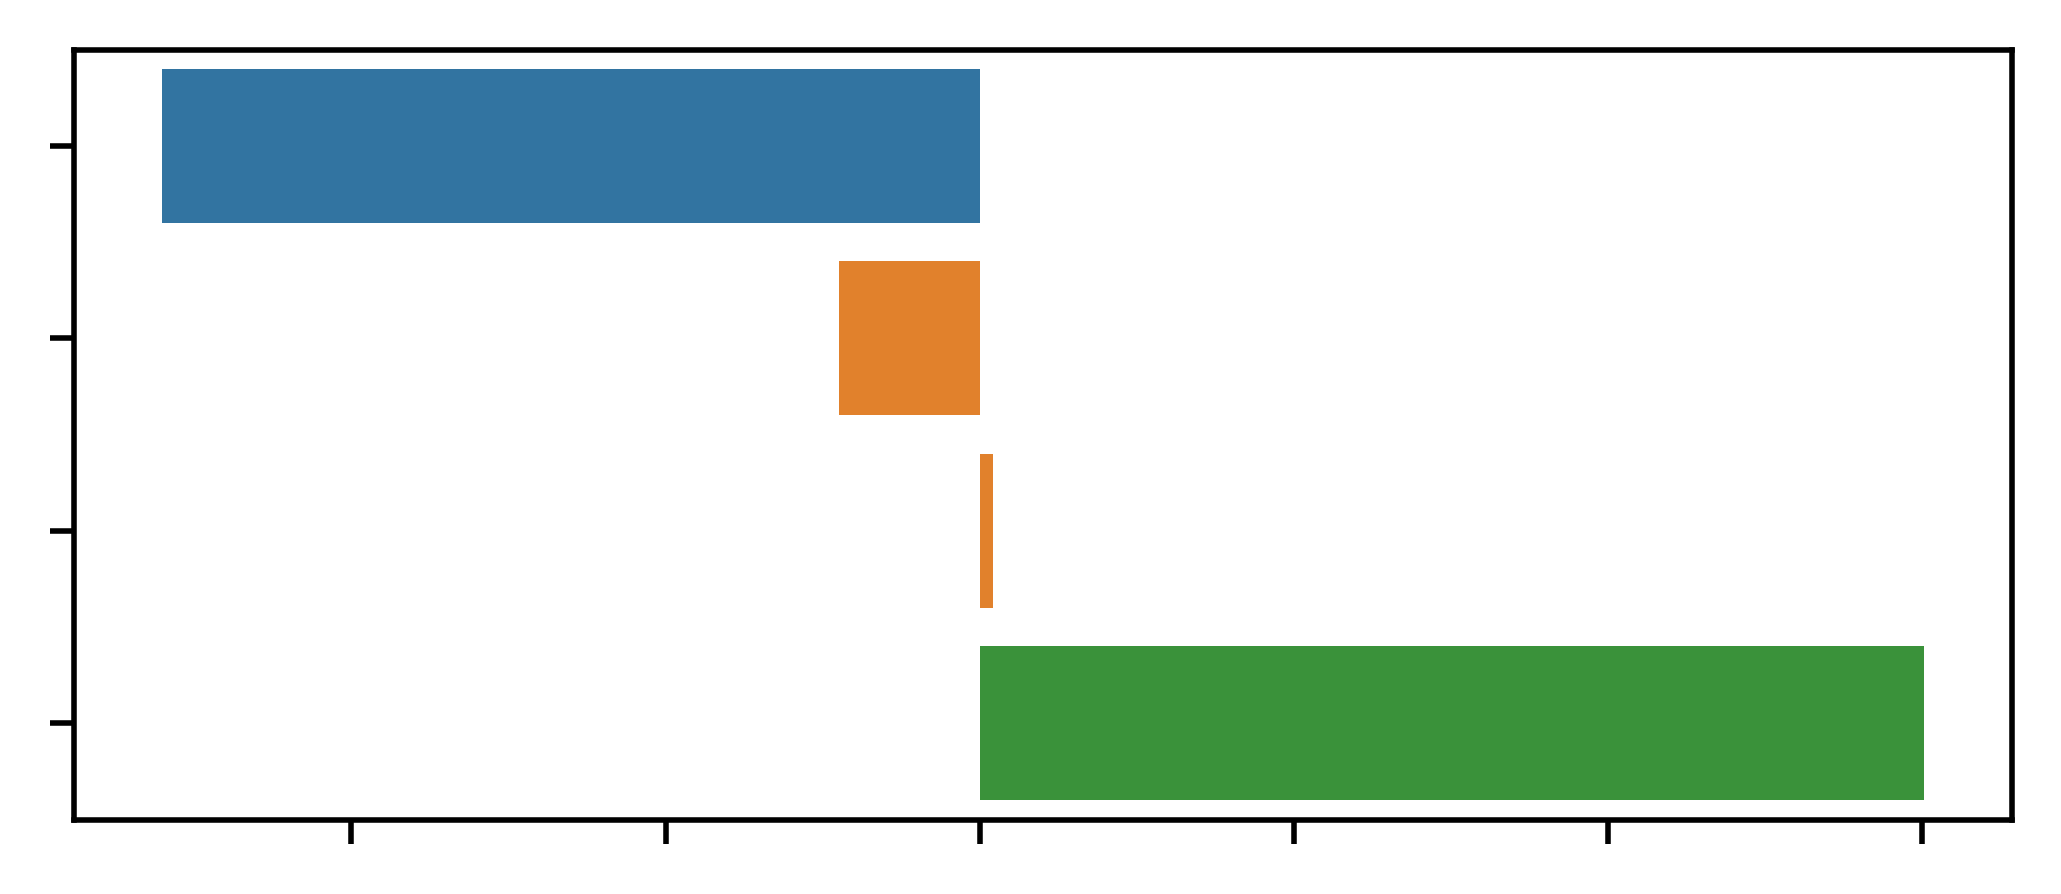

In [10]:
dict_PatientID_to_MSI_class = dict()

# Joanito et al.
MSIintensityByPatient_j = list()
for PatientID, edf in adata_j_tumor.obs.groupby('PatientID'):
    MSIintensityByPatient_j.append( [PatientID, np.mean(edf['MSI_score'])] )
    
MSIintensityByPatient_j = pd.DataFrame(MSIintensityByPatient_j, columns=['PatientID', 'MSI_score',])

u, s = np.mean(MSIintensityByPatient_j['MSI_score']), np.std(MSIintensityByPatient_j['MSI_score'])
MSIintensityByPatient_j['MSI_z_score'] = [ (MSI_score-u)/s for MSI_score in MSIintensityByPatient_j['MSI_score'] ]

for tup in MSIintensityByPatient_j.itertuples():
    if tup.MSI_z_score < -0.5:
        dict_PatientID_to_MSI_class[tup.PatientID] = 'MSI-LI'
    elif tup.MSI_z_score > 0.5:
        dict_PatientID_to_MSI_class[tup.PatientID] = 'MSI-HI'
    else:
        dict_PatientID_to_MSI_class[tup.PatientID] = 'MSI-MI'

MSIintensityByPatient_j['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in MSIintensityByPatient_j['PatientID'] ]

plt.figure(figsize=(5, 2), dpi=500)
ax = sns.barplot(data=MSIintensityByPatient_j.sort_values('MSI_z_score'), y='PatientID', x='MSI_z_score', hue='MSI_class', legend=None)

ax.set_xlabel('');
ax.set_ylabel('');

ax.set_xticklabels([]);
ax.set_yticklabels([]);

# ax.bar_label(fmt='%.2f', container=ax.containers[0]);
# ax.bar_label(fmt='%.2f', container=ax.containers[1]);
# ax.bar_label(fmt='%.2f', container=ax.containers[2]);

/tmp/ipykernel_200359/207256494.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for PatientID, edf in adata_c_tumor.obs.groupby('PatientID'):


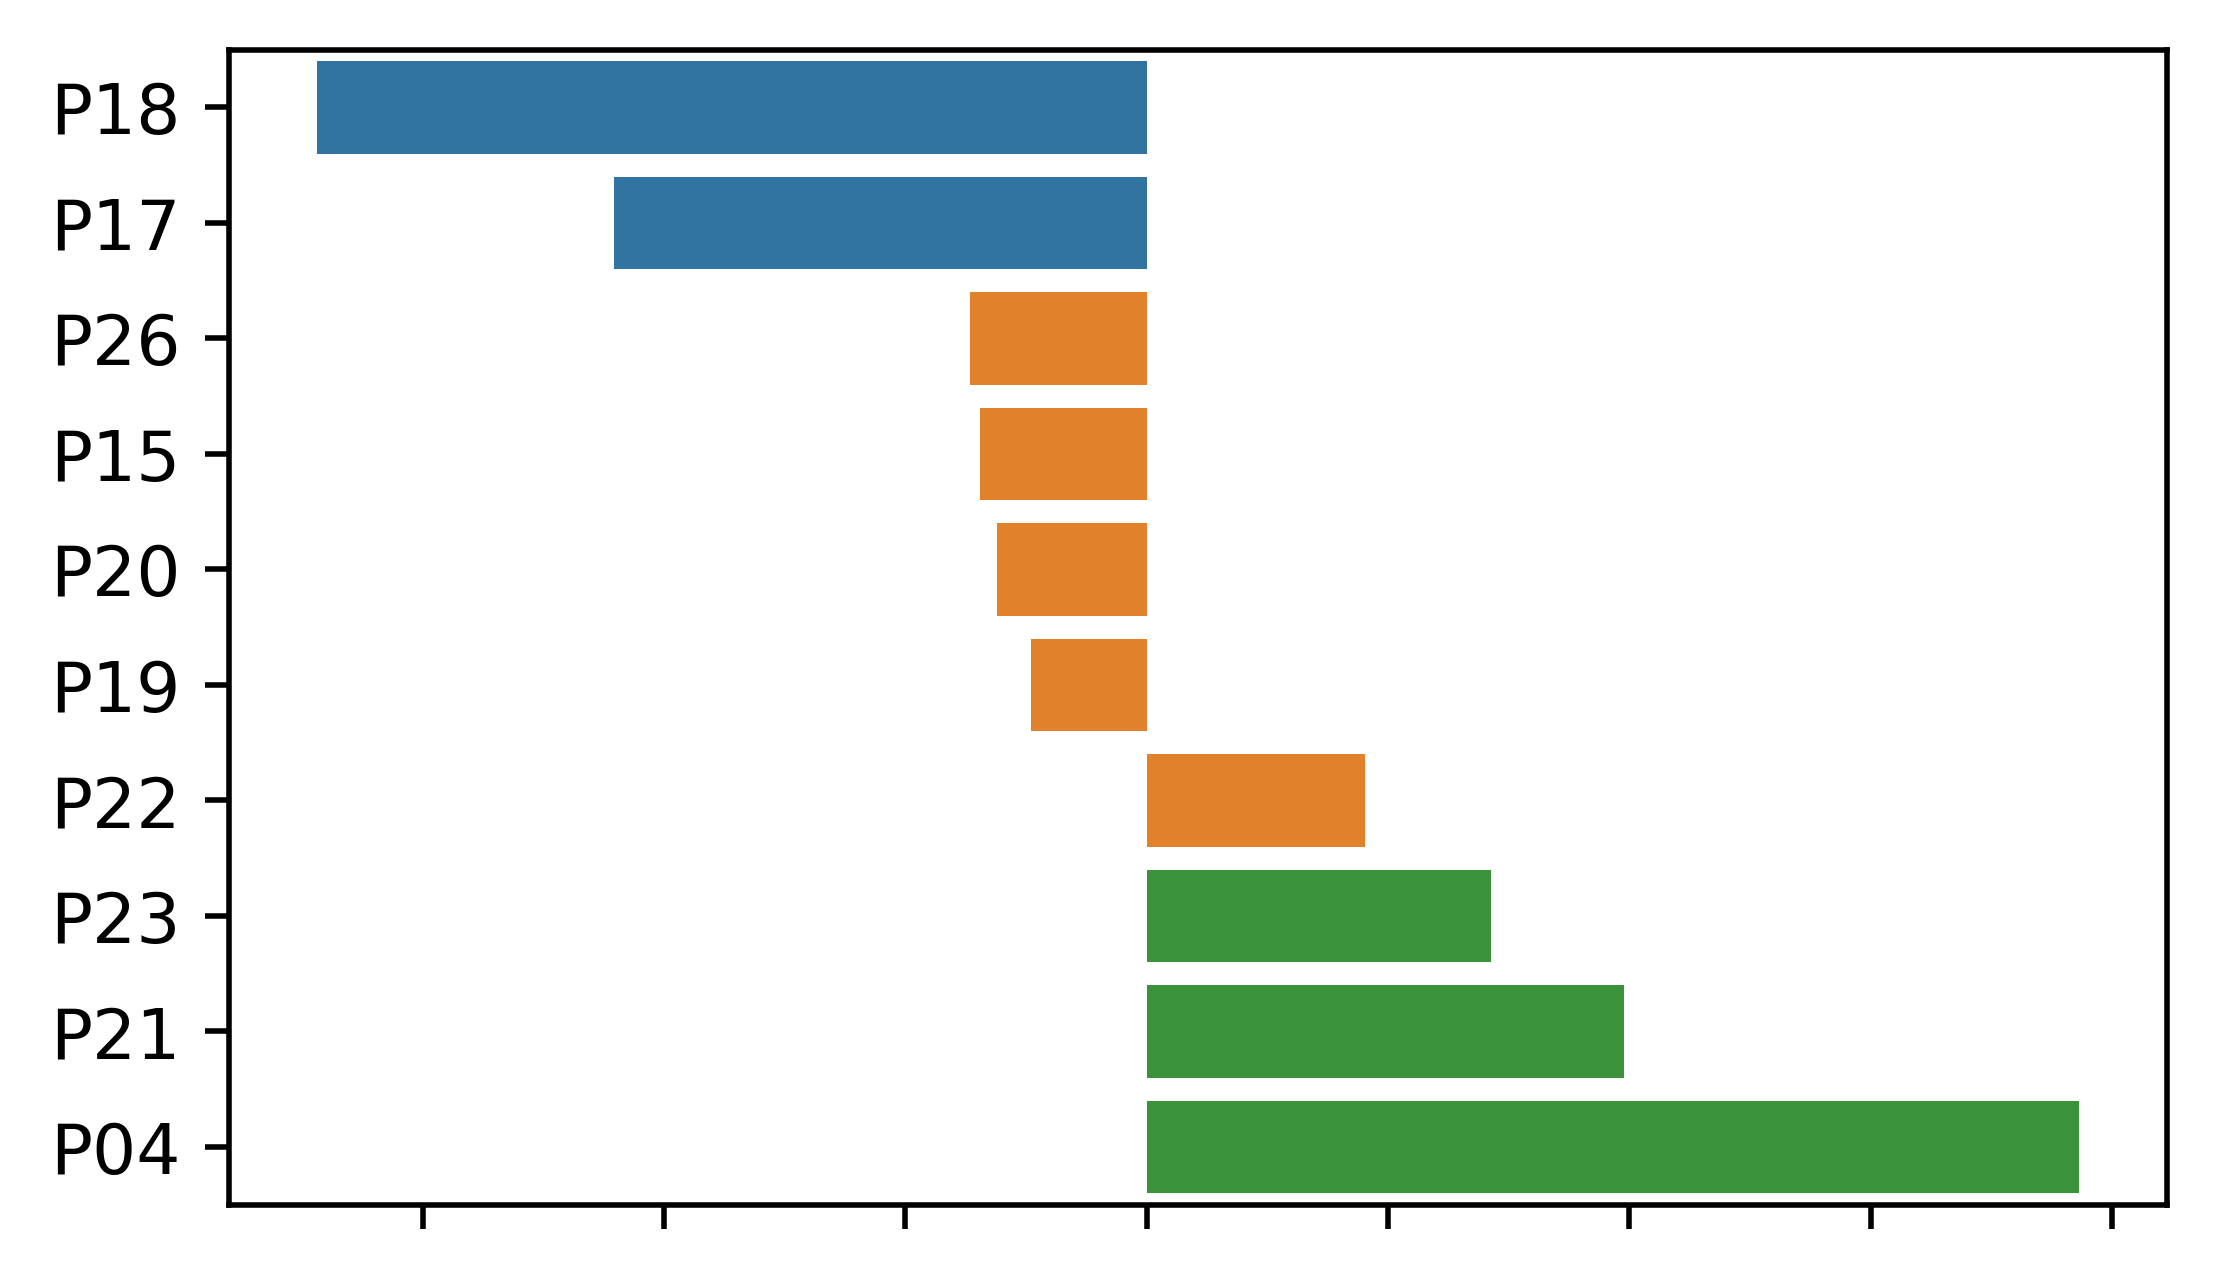

In [11]:
MSIintensityByPatient_c = list()
for PatientID, edf in adata_c_tumor.obs.groupby('PatientID'):
    MSIintensityByPatient_c.append( [PatientID, np.mean(edf['MSI_score'])] )
MSIintensityByPatient_c = pd.DataFrame(MSIintensityByPatient_c, columns=['PatientID', 'MSI_score',])

u, s = np.mean(MSIintensityByPatient_c['MSI_score']), np.std(MSIintensityByPatient_c['MSI_score'])
MSIintensityByPatient_c['MSI_z_score'] = [ (MSI_score-u)/s for MSI_score in MSIintensityByPatient_c['MSI_score'] ]

for tup in MSIintensityByPatient_c.itertuples():
    if tup.MSI_z_score < -0.5:
        dict_PatientID_to_MSI_class[tup.PatientID] = 'MSI-LI'
    elif tup.MSI_z_score > 0.5:
        dict_PatientID_to_MSI_class[tup.PatientID] = 'MSI-HI'
    else:
        dict_PatientID_to_MSI_class[tup.PatientID] = 'MSI-MI'
        
plt.figure(figsize=(5, 3), dpi=500)
MSIintensityByPatient_c['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in MSIintensityByPatient_c['PatientID'] ]
ax = sns.barplot(data=MSIintensityByPatient_c.sort_values('MSI_z_score'), y='PatientID', x='MSI_z_score', hue='MSI_class', legend=None)

ax.set_xlabel('');
ax.set_ylabel('');

ax.set_xticklabels([]);
# ax.set_yticklabels([]);

## DEG identification

### Joanito et al

In [12]:
adata_j_tumor.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in adata_j_tumor.obs['PatientID'] ]
adata_c_tumor.obs['MSI_class'] = [ dict_PatientID_to_MSI_class[PID] for PID in adata_c_tumor.obs['PatientID'] ]

In [13]:
adata_j_tumor_MSI_HI = adata_j_tumor[adata_j_tumor.obs['MSI_class']=='MSI-HI'].copy()
adata_j_tumor_MSI_LI = adata_j_tumor[adata_j_tumor.obs['MSI_class']=='MSI-LI'].copy()

adata_j_tumor_DEG_analysis = sc.concat([adata_j_tumor_MSI_HI, adata_j_tumor_MSI_LI])

minimum_cell_percentage = 0.03
sc.pp.filter_genes(adata_j_tumor_DEG_analysis, min_cells=int(adata_j_tumor_DEG_analysis.obs.shape[0]*minimum_cell_percentage))
adata_j_tumor_DEG_analysis.shape

(1700, 13112)

In [14]:
sc.pp.normalize_total(adata_j_tumor_DEG_analysis)
sc.pp.log1p(adata_j_tumor_DEG_analysis)
adata_j_tumor_DEG_analysis.raw = adata_j_tumor_DEG_analysis.copy()

sc.tl.rank_genes_groups(adata_j_tumor_DEG_analysis, groupby='MSI_class', method='wilcoxon', )

In [15]:
joanito_tumor_DEG_names = pd.DataFrame(adata_j_tumor_DEG_analysis.uns['rank_genes_groups']['names'])
joanito_tumor_DEG_score = pd.DataFrame(adata_j_tumor_DEG_analysis.uns['rank_genes_groups']['scores'])
joanito_tumor_DEG_lfc   = pd.DataFrame(adata_j_tumor_DEG_analysis.uns['rank_genes_groups']['logfoldchanges'])
joanito_tumor_DEG_p     = pd.DataFrame(adata_j_tumor_DEG_analysis.uns['rank_genes_groups']['pvals'])
joanito_tumor_DEG_adjp  = pd.DataFrame(adata_j_tumor_DEG_analysis.uns['rank_genes_groups']['pvals_adj'])

joanito_tumor_DEG_summary = list()
dict_idx_to_MSI_class = { 0 : 'MSI-HI', 1 : 'MSI-LI' }

for tup in joanito_tumor_DEG_names.itertuples():
    for idx, elem in enumerate(list(tup)[1:]):
        joanito_tumor_DEG_summary.append( [elem, 
                                           list(joanito_tumor_DEG_score.iloc[tup.Index])[idx], 
                                           list(joanito_tumor_DEG_lfc.iloc[tup.Index])[idx], 
                                           list(joanito_tumor_DEG_p.iloc[tup.Index])[idx], 
                                           list(joanito_tumor_DEG_adjp.iloc[tup.Index])[idx], 
                                           dict_idx_to_MSI_class[idx] ] ) 

joanito_tumor_DEG_summary = pd.DataFrame(joanito_tumor_DEG_summary, columns=['gene', 'score', 'logfoldchanges', 'pvalue', 'adjusted_pvalue', 'MSI_class'])
joanito_tumor_DEG_summary.to_csv(f'{DIR_OUT}/ScanpyRankGenesGroups.Joanito_et_al.summary.tsv', sep='\t', index=False)

### Chen et al

In [16]:
adata_c_tumor_MSI_HI = adata_c_tumor[adata_c_tumor.obs['MSI_class']=='MSI-HI'].copy()
adata_c_tumor_MSI_LI = adata_c_tumor[adata_c_tumor.obs['MSI_class']=='MSI-LI'].copy()

adata_c_tumor_DEG_analysis = sc.concat([adata_c_tumor_MSI_HI, adata_c_tumor_MSI_LI])

minimum_cell_percentage = 0.03
sc.pp.filter_genes(adata_c_tumor_DEG_analysis, min_cells=int(adata_c_tumor_DEG_analysis.obs.shape[0]*minimum_cell_percentage))
adata_c_tumor_DEG_analysis.shape

(8727, 12146)

In [17]:
sc.pp.normalize_total(adata_c_tumor_DEG_analysis)
sc.pp.log1p(adata_c_tumor_DEG_analysis)
adata_c_tumor_DEG_analysis.raw = adata_c_tumor_DEG_analysis.copy()

sc.tl.rank_genes_groups(adata_c_tumor_DEG_analysis, groupby='MSI_class', method='wilcoxon', )

In [18]:
chen_tumor_DEG_names = pd.DataFrame(adata_c_tumor_DEG_analysis.uns['rank_genes_groups']['names'])
chen_tumor_DEG_score = pd.DataFrame(adata_c_tumor_DEG_analysis.uns['rank_genes_groups']['scores'])
chen_tumor_DEG_lfc   = pd.DataFrame(adata_c_tumor_DEG_analysis.uns['rank_genes_groups']['logfoldchanges'])
chen_tumor_DEG_p  = pd.DataFrame(adata_c_tumor_DEG_analysis.uns['rank_genes_groups']['pvals'])
chen_tumor_DEG_adjp  = pd.DataFrame(adata_c_tumor_DEG_analysis.uns['rank_genes_groups']['pvals_adj'])

chen_tumor_DEG_summary = list()
dict_idx_to_MSI_class = { 0 : 'MSI-HI', 1 : 'MSI-LI' }

for tup in chen_tumor_DEG_names.itertuples():
    for idx, elem in enumerate(list(tup)[1:]):
        chen_tumor_DEG_summary.append( [elem, 
                                           list(chen_tumor_DEG_score.iloc[tup.Index])[idx], 
                                           list(chen_tumor_DEG_lfc.iloc[tup.Index])[idx], 
                                           list(chen_tumor_DEG_p.iloc[tup.Index])[idx], 
                                           list(chen_tumor_DEG_adjp.iloc[tup.Index])[idx], 
                                           dict_idx_to_MSI_class[idx] ] ) 

chen_tumor_DEG_summary = pd.DataFrame(chen_tumor_DEG_summary, columns=['gene', 'score', 'logfoldchanges', 'pvalue', 'adjusted_pvalue', 'MSI_class'])
chen_tumor_DEG_summary.to_csv(f'{DIR_OUT}ScanpyRankGenesGroups.Chen_et_al.summary.tsv', sep='\t', index=False)

### Visualize DEGs through Volcano plots (Fig. 3a)

In [19]:
joanito_tumor_DEG_summary   = pd.read_csv(f'{DIR_OUT}/ScanpyRankGenesGroups.Joanito_et_al.summary.tsv', sep='\t')
chen_tumor_DEG_summary      = pd.read_csv(f'{DIR_OUT}/ScanpyRankGenesGroups.Chen_et_al.summary.tsv', sep='\t')

joanito_tumor_DEG_summary   = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['MSI_class']=='MSI-HI'].copy()
chen_tumor_DEG_summary      = chen_tumor_DEG_summary[chen_tumor_DEG_summary['MSI_class']=='MSI-HI'].copy()

In [20]:
chen_tumor_DEG_summary['adjusted_pvalue']       = chen_tumor_DEG_summary['adjusted_pvalue'].replace(0, min(chen_tumor_DEG_summary[(chen_tumor_DEG_summary['adjusted_pvalue']!=0)]['adjusted_pvalue']))
joanito_tumor_DEG_summary['adjusted_pvalue']    = joanito_tumor_DEG_summary['adjusted_pvalue'].replace(0, min(joanito_tumor_DEG_summary[(joanito_tumor_DEG_summary['adjusted_pvalue']!=0)]['adjusted_pvalue']))

In [21]:
joanito_tumor_DEG_summary_sig   = joanito_tumor_DEG_summary[(joanito_tumor_DEG_summary['adjusted_pvalue']<=0.01)].copy()
chen_tumor_DEG_summary_sig      = chen_tumor_DEG_summary[(chen_tumor_DEG_summary['adjusted_pvalue']<=0.01)].copy()

joanito_down = joanito_tumor_DEG_summary_sig[(joanito_tumor_DEG_summary_sig['logfoldchanges']<=-1) ]
joanito_up = joanito_tumor_DEG_summary_sig[(joanito_tumor_DEG_summary_sig['logfoldchanges']>=1) ]

chen_down = chen_tumor_DEG_summary_sig[(chen_tumor_DEG_summary_sig['logfoldchanges']<=-1) ]
chen_up = chen_tumor_DEG_summary_sig[(chen_tumor_DEG_summary_sig['logfoldchanges']>=1) ]

print(f'Joanito up: {len(joanito_up)}\tJoanito down: {len(joanito_down)}')
print(f'Chen up: {len(chen_up)}\tChen down: {len(chen_down)}')

Joanito up: 3754	Joanito down: 1225
Chen up: 710	Chen down: 953


In [22]:
intersecting_up     = set(joanito_up['gene']).intersection(set(chen_up['gene']))
intersecting_down   = set(joanito_down['gene']).intersection(set(chen_down['gene']))

print(len(intersecting_up), len(intersecting_down))

237 176


#### Joanito et al

In [42]:
geneoi = 'LRIG1'
# geneoi = None
joanito_tumor_DEG_summary_geneoi = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['gene']==geneoi]

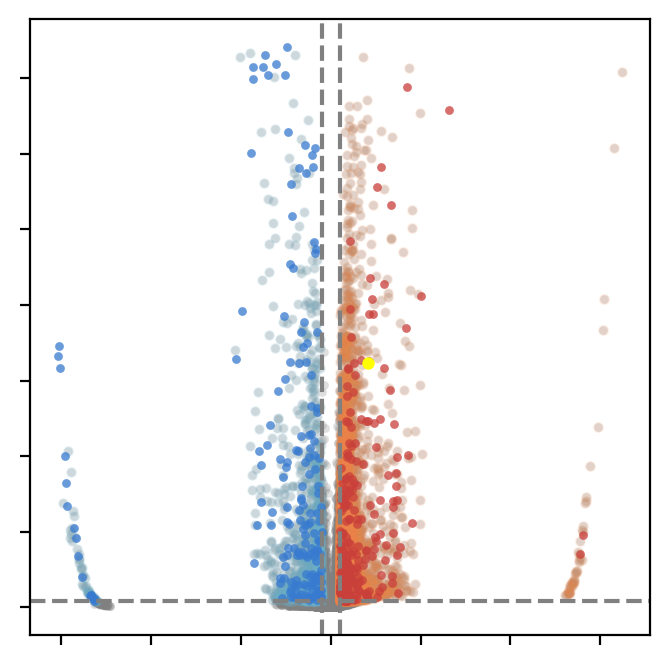

In [43]:
plt.figure(figsize=(4, 4), dpi=200)

# up and down are genes that are found in both Joanito et al. and Chen et al. DEGs
up      = joanito_tumor_DEG_summary[joanito_tumor_DEG_summary['gene'].isin(intersecting_up) & (joanito_tumor_DEG_summary['gene']!=geneoi)]
down    = joanito_tumor_DEG_summary[(joanito_tumor_DEG_summary['gene'].isin(intersecting_down))].copy()

# up2 and down2 are genes that are only found in Jonaito et al DEGs.
up2     = joanito_tumor_DEG_summary[(joanito_tumor_DEG_summary['logfoldchanges']>=1) & (joanito_tumor_DEG_summary['adjusted_pvalue']<=0.01)]
up2     = up2[~up2['gene'].isin(up['gene'])]
down2   = joanito_tumor_DEG_summary[(joanito_tumor_DEG_summary['logfoldchanges']<=-1)&(joanito_tumor_DEG_summary['adjusted_pvalue']<=0.01)]
down2   = down2[~down2['gene'].isin(down['gene'])]

    
ax = sns.scatterplot(x=joanito_tumor_DEG_summary[~(joanito_tumor_DEG_summary['gene'].isin(set(down['gene']).union(set(up['gene']))))]['logfoldchanges'], 
                y=joanito_tumor_DEG_summary[~(joanito_tumor_DEG_summary['gene'].isin(set(down['gene']).union(set(up['gene']))))]['adjusted_pvalue'].apply(lambda x:-np.log10(x)),
                s=10, 
                alpha=0.25, 
                color='gray',
                 **{'linewidths':0},
                )

ax = sns.scatterplot(x=down2['logfoldchanges'],y=down2['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=15, 
            # label="Enriched in MSI-L",
            color=sns.color_palette('icefire_r', 8)[-1], alpha=.15, **{'linewidths':0})
ax = sns.scatterplot(x=up2['logfoldchanges'],y=up2['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=15,
            # label="Enriched in MSI-H",
            color=sns.color_palette('icefire_r', 8)[0], alpha=.15,  **{'linewidths':0})

ax = sns.scatterplot(x=down['logfoldchanges'],y=down['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=10, 
            # label="Enriched in MSI-L",
            # color=sns.color_palette('vlag_r', 8)[-1], 
            color=sns.color_palette('icefire_r', 8)[-2],            
            alpha=.75, **{'linewidths':0})

ax = sns.scatterplot(x=up['logfoldchanges'],y=up['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=10,
            # label="Enriched in MSI-H",
            # color=sns.color_palette('vlag_r', 8)[0], 
            color=sns.color_palette('icefire_r', 8)[1],            
            alpha=.75, **{'linewidths':0})

if geneoi != None:
    ax = sns.scatterplot(x=joanito_tumor_DEG_summary_geneoi['logfoldchanges'],y=joanito_tumor_DEG_summary_geneoi['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=20, 
                # label="Enriched in MSI-L",
                # color=sns.color_palette('icefire_r', 8)[-1], 
                color='yellow',
                alpha=1, **{'linewidths':0})

ax.set_xticklabels([]);
ax.set_yticklabels([]);

# plt.xlabel("logFC")
# plt.ylabel("-logFDR")
plt.xlabel("")
plt.ylabel("")
plt.axvline(-1,color="grey",linestyle="--")
plt.axvline(1,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
# plt.xlim([-10, 10]);

#### Chen et al

In [44]:
geneoi = 'LRIG1'
# geneoi = None
chen_tumor_DEG_summary_geneoi = chen_tumor_DEG_summary[chen_tumor_DEG_summary['gene']==geneoi]

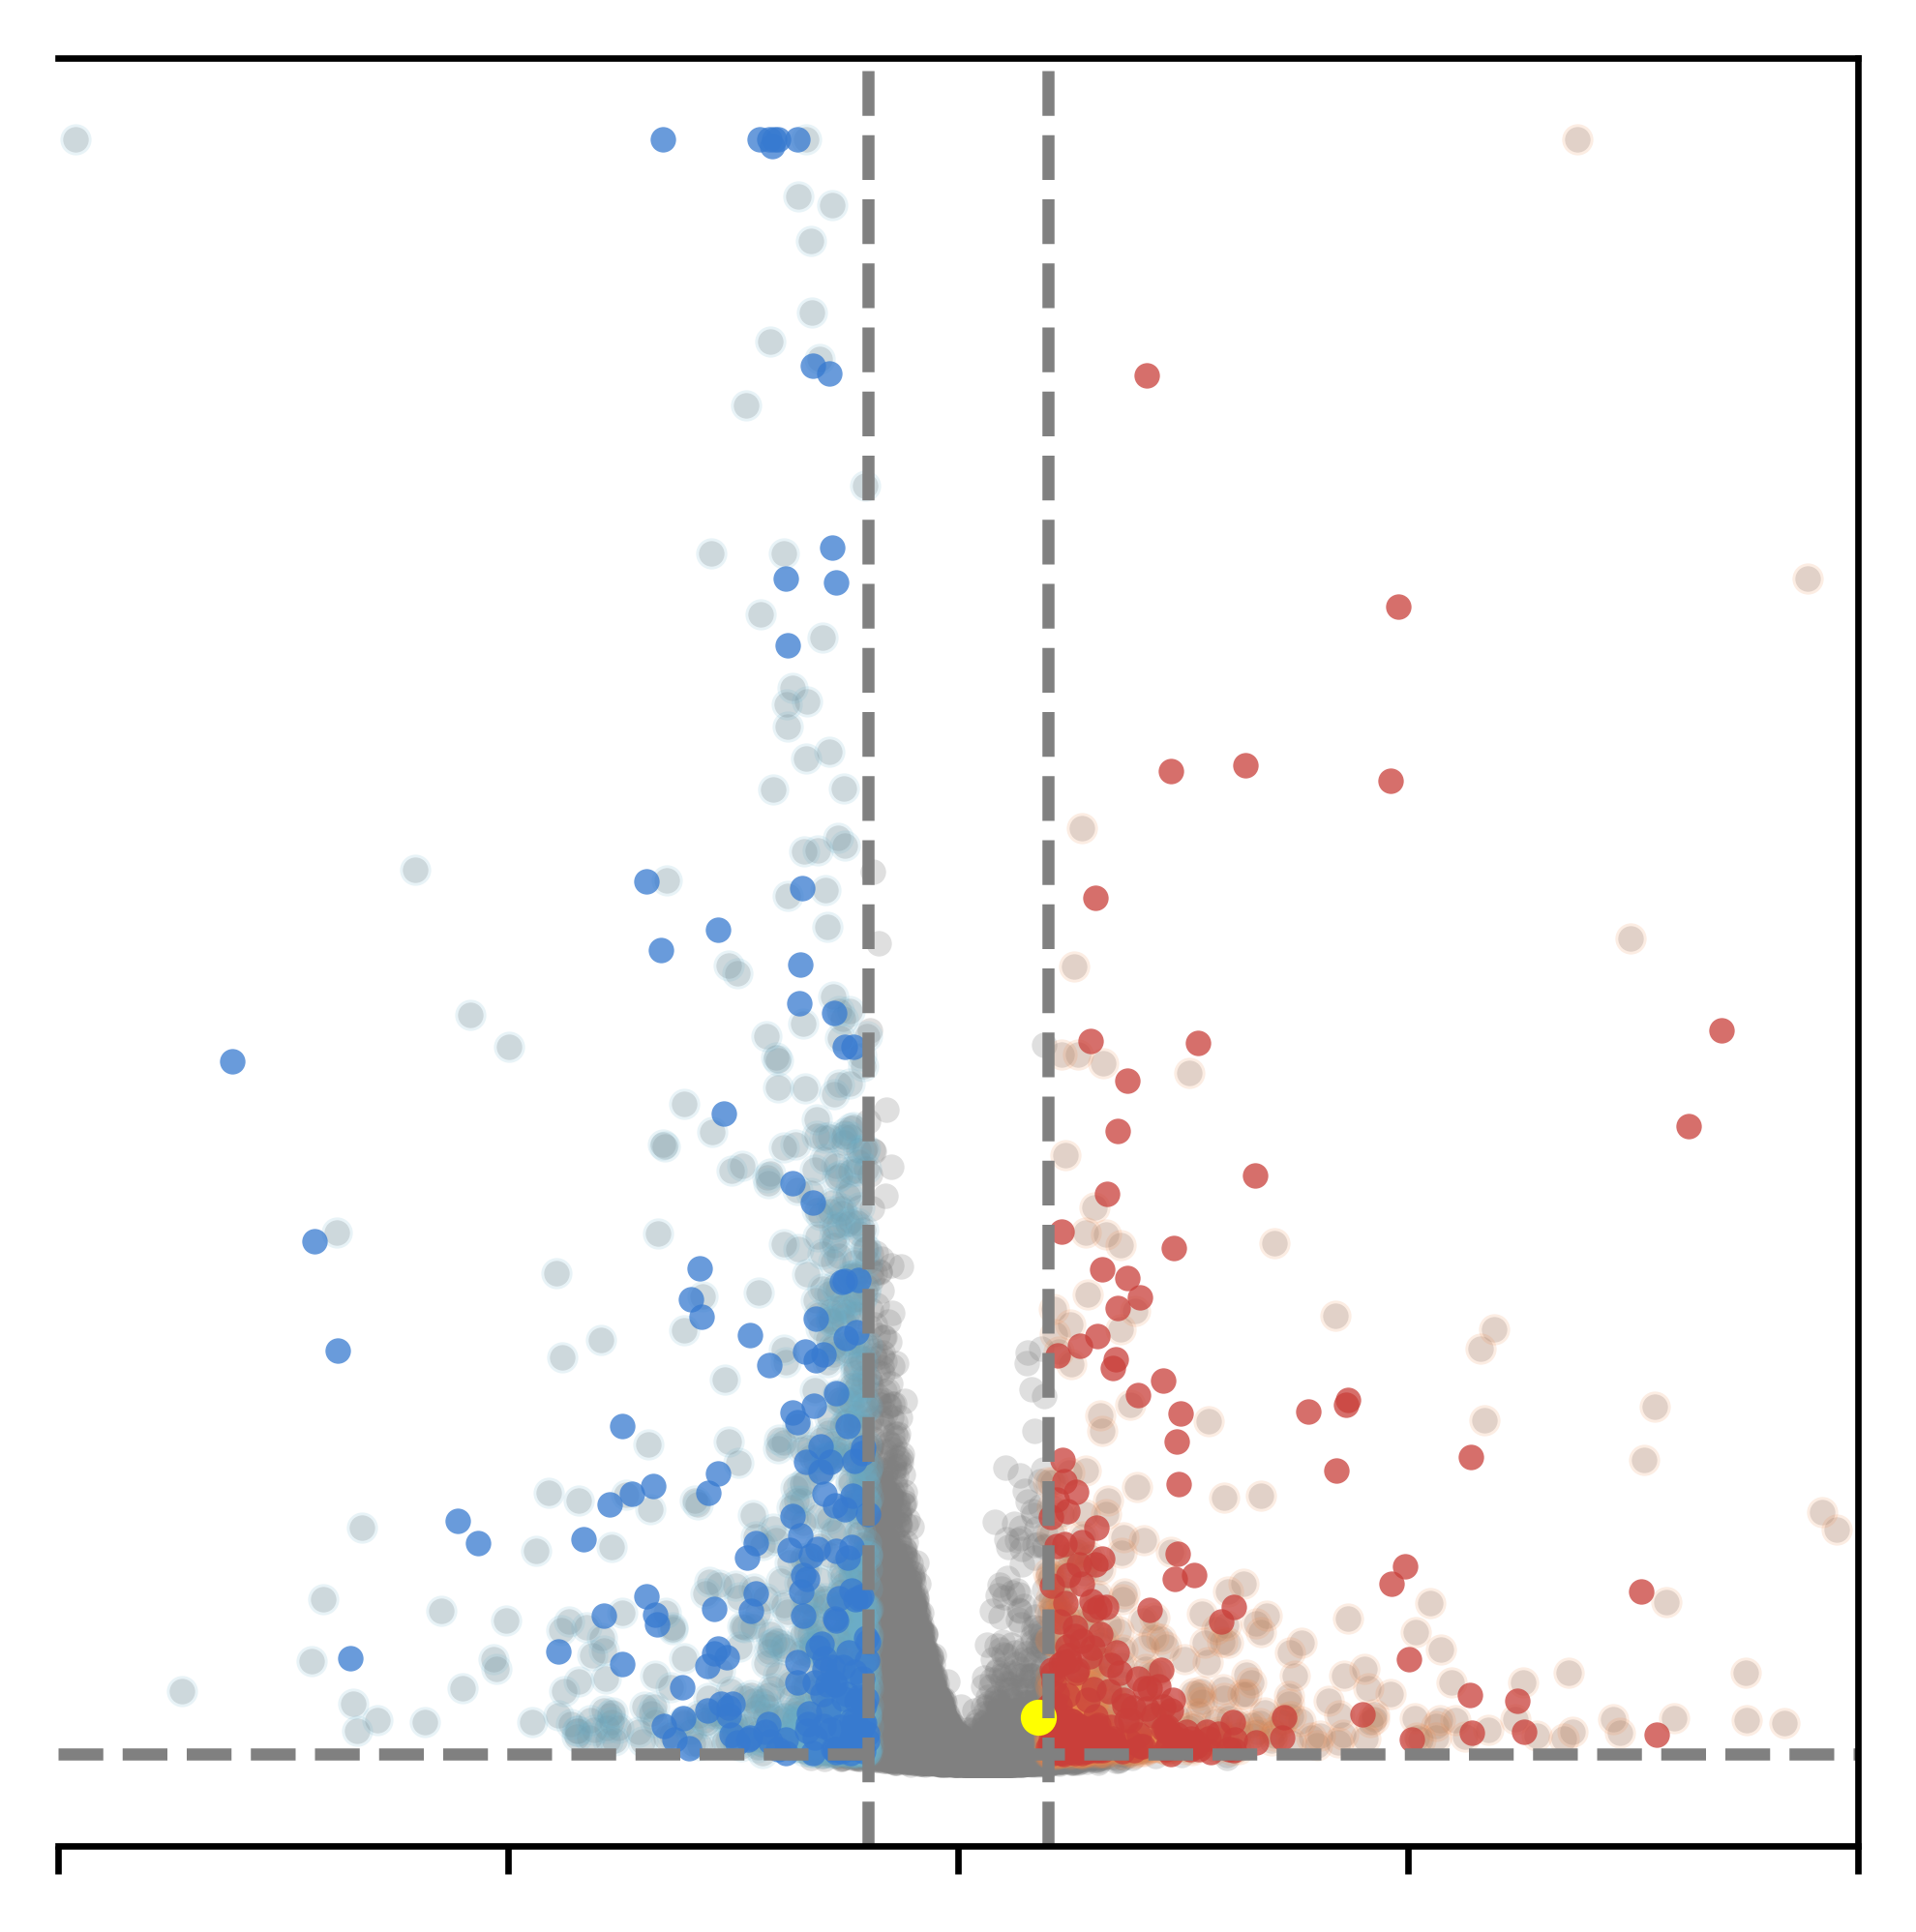

In [45]:
plt.figure(figsize=(4, 4), dpi=600)

# up and down are genes that are found in both Joanito et al. and Chen et al. DEGs
up      = chen_tumor_DEG_summary[chen_tumor_DEG_summary['gene'].isin(intersecting_up)]
down    = chen_tumor_DEG_summary[(chen_tumor_DEG_summary['gene'].isin(intersecting_down))].copy()

# up2 and down2 are genes that are only found in Jonaito et al DEGs.
up2     = chen_tumor_DEG_summary[(chen_tumor_DEG_summary['logfoldchanges']>=1) & (chen_tumor_DEG_summary['adjusted_pvalue']<=0.01)]
up2     = up2[~up2['gene'].isin(up['gene'])]
down2   = chen_tumor_DEG_summary[(chen_tumor_DEG_summary['logfoldchanges']<=-1)&(chen_tumor_DEG_summary['adjusted_pvalue']<=0.01)]
down2   = down2[~down2['gene'].isin(down['gene'])]
    
ax = sns.scatterplot(x=chen_tumor_DEG_summary[~(chen_tumor_DEG_summary['gene'].isin(set(down['gene']).union(set(up['gene']))))]['logfoldchanges'], 
                y=chen_tumor_DEG_summary[~(chen_tumor_DEG_summary['gene'].isin(set(down['gene']).union(set(up['gene']))))]['adjusted_pvalue'].apply(lambda x:-np.log10(x)),
                s=10, 
                alpha=0.25, 
                color='gray',
                 **{'linewidths':0},
                )

ax = sns.scatterplot(x=down2['logfoldchanges'],y=down2['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=15, 
            # label="Enriched in MSI-L",
            color=sns.color_palette('icefire_r', 8)[-1], alpha=.15, **{'linewidths':0})
ax = sns.scatterplot(x=up2['logfoldchanges'],y=up2['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=15,
            # label="Enriched in MSI-H",
            color=sns.color_palette('icefire_r', 8)[0], alpha=.15,  **{'linewidths':0})

ax = sns.scatterplot(x=down['logfoldchanges'],y=down['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=10, 
            # label="Enriched in MSI-L",
            # color=sns.color_palette('vlag_r', 8)[-1], 
            color=sns.color_palette('icefire_r', 8)[-2],            
            alpha=.75, **{'linewidths':0})

ax = sns.scatterplot(x=up['logfoldchanges'],y=up['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=10,
            # label="Enriched in MSI-H",
            # color=sns.color_palette('vlag_r', 8)[0], 
            color=sns.color_palette('icefire_r', 8)[1],            
            alpha=.75, **{'linewidths':0})

if geneoi != None:
    ax = sns.scatterplot(x=chen_tumor_DEG_summary_geneoi['logfoldchanges'],
                         y=chen_tumor_DEG_summary_geneoi['adjusted_pvalue'].apply(lambda x:-np.log10(x)), s=20, 
                # label="Enriched in MSI-L",
                # color=sns.color_palette('icefire_r', 8)[-1], 
                color='yellow',
                alpha=1, **{'linewidths':0})

ax.set_xticklabels([]);
ax.set_yticklabels([]);

# plt.xlabel("logFC")
# plt.ylabel("-logFDR")
plt.xlabel("")
plt.ylabel("")
plt.axvline(-1,color="grey",linestyle="--")
plt.axvline(1,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")

plt.xlim([-10, 10]);
# plt.xlim([-25, -24.5]);

ax.set_yticks([]);

sns.despine(left=True, top=False, right=False,)

## Cell-type characterization of selected DEGs using Human Protein Atlas data (Supplementary Fig. 1b)

In [7]:
HumanAtlasProtein = pd.read_csv(PATH_TO_HUMAN_ATLAS_DATA, sep='\t')
HumanAtlasProtein = HumanAtlasProtein[(HumanAtlasProtein['Tissue']=='colon')].copy()

All genes found


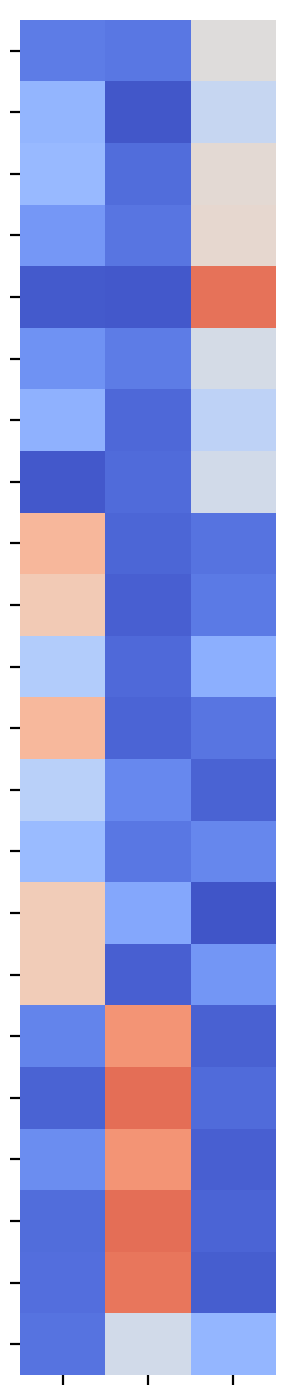

In [98]:
GenesOfInterest = [ 'RGMB', 'ASCL2', 'SOX4', 'NUPR1', 'PHGDH', 'NFIA' ,'NFIB', 'LEF1', 
                   'S100A6', 'S100A10', 'S100A11', 'S100A14', 'S100P', 'CD55', 'TFF1', 'PIGR',
                   'TFF3', 'ATOH1', 'MUC2', 'SPINK4', 'REG4', 'PRUNE2' ]
HumanAtlasProtein_GenesOfInterest = HumanAtlasProtein[(HumanAtlasProtein['Gene name'].isin(GenesOfInterest))].copy()
if set(HumanAtlasProtein_GenesOfInterest['Gene name']) == set(GenesOfInterest):
    print("All genes found")
else:
    print(f"Some genes missing: {set(GenesOfInterest).difference(set(HumanAtlasProtein_GenesOfInterest['Gene name']))}")    

HumanAtlasProtein_GenesOfInterest_organized = list()
for gene, edf in HumanAtlasProtein_GenesOfInterest.groupby('Gene name', observed=True):
    for cell_type, edf2 in edf.groupby('Cell type', observed=True):
        HumanAtlasProtein_GenesOfInterest_organized.append( [gene, cell_type, sum(edf2['nTPM'])] )

HumanAtlasProtein_GenesOfInterest_organized = pd.DataFrame(HumanAtlasProtein_GenesOfInterest_organized, columns=['gene', 'celltype', 'nTPM'])

dict_gene_to_total_nTPM = { gene : sum(edf['nTPM']) for gene, edf in HumanAtlasProtein_GenesOfInterest_organized.groupby('gene') }
HumanAtlasProtein_GenesOfInterest_organized['nTPM_portion'] = [ tup.nTPM / dict_gene_to_total_nTPM[tup.gene] for tup in HumanAtlasProtein_GenesOfInterest_organized.itertuples() ]
HumanAtlasProtein_GenesOfInterest_organized_pivot = HumanAtlasProtein_GenesOfInterest_organized.pivot(columns='celltype', index='gene', values='nTPM_portion').reindex( GenesOfInterest )
# HumanAtlasProtein_GenesOfInterest_organized_pivot = HumanAtlasProtein_GenesOfInterest_organized_pivot[['distal enterocytes', 'intestinal goblet cells', 'undifferentiated cells', 'enteroendocrine cells', 'paneth cells', 't-cells']]
HumanAtlasProtein_GenesOfInterest_organized_pivot = HumanAtlasProtein_GenesOfInterest_organized_pivot[['distal enterocytes', 'intestinal goblet cells', 'undifferentiated cells', ]]

plt.figure(figsize=(1.65, 8.8), dpi=200)
ax = sns.heatmap(HumanAtlasProtein_GenesOfInterest_organized_pivot, 
                 # cmap='viridis', 
                 cmap = sns.color_palette("coolwarm", as_cmap=True),
                 vmin=0, vmax=1, 
                 cbar=None,)
ax.set_xlabel('');
ax.set_ylabel('');
ax.set_xticklabels([]);
ax.set_yticklabels([]);

## ORA analysis of DEGs (Fig. 3c)

In [24]:
EnrichR_intersecting_up = gp.enrichr(gene_list=list(intersecting_up),
                                    gene_sets=['CellMarker_2024'],
                                    organism='human', 
                                    # background="/node200data/18parkky/datasets/data/public/processed_data/CRC_MSI_intensity_analysis/DEGs/BackgroundGenes.txt",
                                    outdir=None, 
                                    )

EnrichR_intersecting_dw = gp.enrichr(gene_list=list(intersecting_down), # or "./tests/data/gene_list.txt",
                                    gene_sets=['CellMarker_2024'],  
                                    # gene_sets=['CellMarker_2024'],                                  
                                    organism='human',
                                    # background="/node200data/18parkky/datasets/data/public/processed_data/CRC_MSI_intensity_analysis/DEGs/BackgroundGenes.txt", 
                                    outdir=None, 
                                    )

In [26]:
EnrichR_intersecting_up_CellMarkerResults = EnrichR_intersecting_up.results[(EnrichR_intersecting_up.results['Gene_set']=='CellMarker_2024')].copy()
EnrichR_intersecting_dw_CellMarkerResults = EnrichR_intersecting_dw.results[(EnrichR_intersecting_dw.results['Gene_set']=='CellMarker_2024')].copy()

EnrichR_intersecting_up_CellMarkerResults['Organism'] = [ Term.split(' ')[-1] for Term in EnrichR_intersecting_up_CellMarkerResults['Term'] ]
EnrichR_intersecting_dw_CellMarkerResults['Organism'] = [ Term.split(' ')[-1] for Term in EnrichR_intersecting_dw_CellMarkerResults['Term'] ]

EnrichR_intersecting_up_CellMarkerResults = EnrichR_intersecting_up_CellMarkerResults[(EnrichR_intersecting_up_CellMarkerResults['Organism']=='Human')]
EnrichR_intersecting_dw_CellMarkerResults = EnrichR_intersecting_dw_CellMarkerResults[(EnrichR_intersecting_dw_CellMarkerResults['Organism']=='Human')]

EnrichR_intersecting_up_CellMarkerResults['n_genes'] = [ len(Genes.split(';')) for Genes in EnrichR_intersecting_up_CellMarkerResults['Genes'] ]
EnrichR_intersecting_dw_CellMarkerResults['n_genes'] = [ len(Genes.split(';')) for Genes in EnrichR_intersecting_dw_CellMarkerResults['Genes'] ]

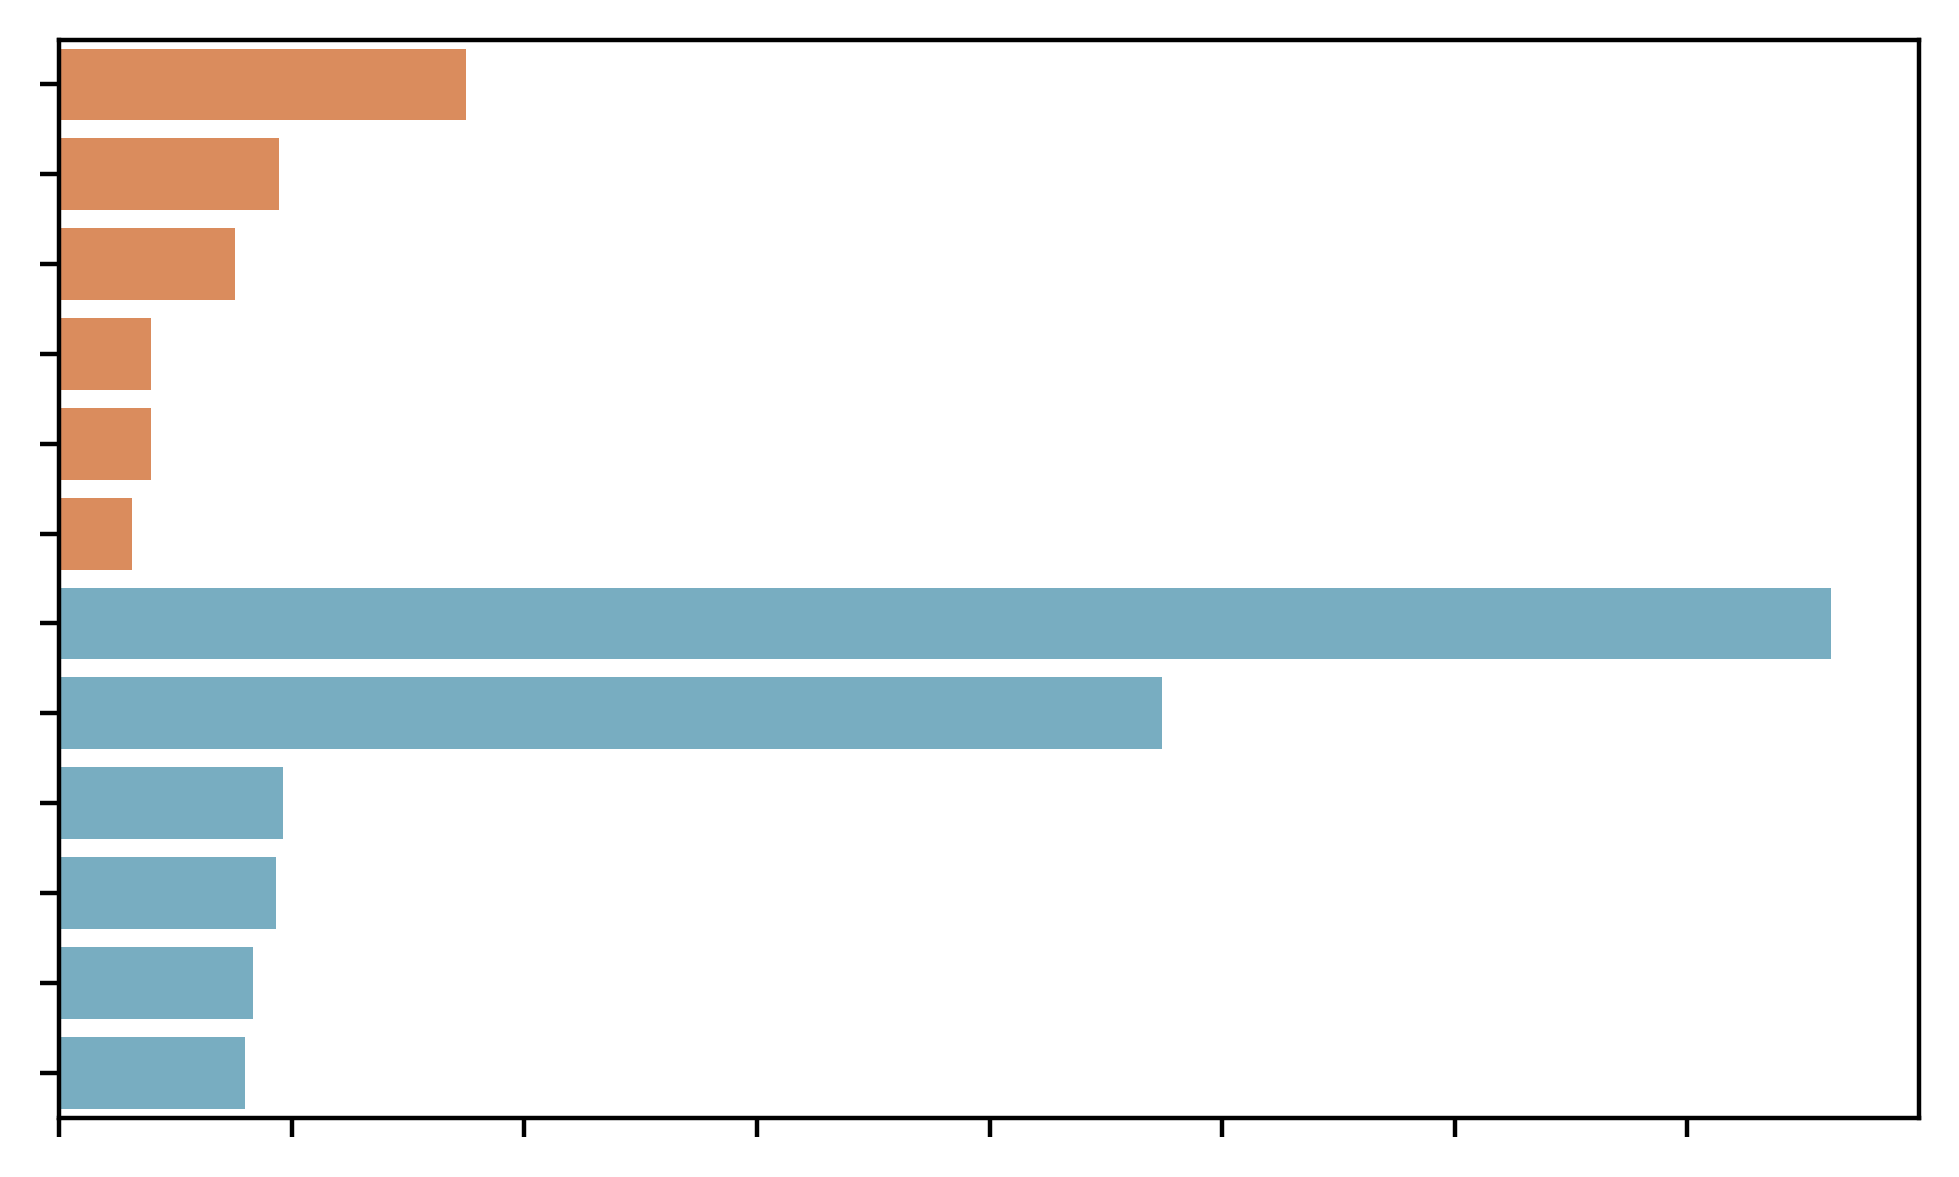

In [29]:
EnrichR_intersecting_up_CellMarkerResults['class'] = 'MSI-H'
EnrichR_intersecting_dw_CellMarkerResults['class'] = 'MSI-L'
EnrichR_CellMarkerResults = pd.concat([EnrichR_intersecting_up_CellMarkerResults.sort_values(['Combined Score', 'n_genes',], ascending=False,).head(6), 
                                       EnrichR_intersecting_dw_CellMarkerResults.sort_values(['Combined Score', 'n_genes',], ascending=False,).head(6)])

plt.figure(figsize=(6, 3.5), dpi=400)
ax = sns.barplot(data=EnrichR_CellMarkerResults, y='Term', x='Combined Score', hue='class', palette={'MSI-H' : sns.color_palette('icefire', 8)[-1], 'MSI-L':sns.color_palette('icefire', 8)[0]}, legend=None,)
ax.set_xlabel('');
ax.set_ylabel('');
# ax.set_xticklabels([]);
# ax.set_yticklabels([]);

## GSEA of various gene sets (Fig. 3d)

In [33]:
def get_GSEA_results( adata, gene_sets, min_size=15 ):
    result = adata.uns['rank_genes_groups']
    # result = adata_epi_chen_tumor_DEGs.uns['rank_genes_groups']

    groups = result['names'].dtype.names
    degs = pd.DataFrame(
        {group + '_' + key: result[key][group]
        for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})
    
    pre_res = gp.prerank(degs.loc[:,['MSI-HI_names', 'MSI-HI_logfoldchanges']], gene_sets=gene_sets, min_size=min_size)
    return pre_res

In [76]:
gsea_geneset = pd.read_csv(PATH_TO_GSEA_GENESET, sep='\t')

custom_geneset = {
          "Fetal signature": list(gsea_geneset['Fetal signature'].dropna()),
          "Metaplasia signature": list(gsea_geneset['Metaplasia signature'].dropna()),
          "Wnt/Stem signature": list(gsea_geneset['Wnt/Stem signature'].dropna()),
          
          "Large intestine goblet markers": list(gsea_geneset['Large intestine goblet markers'].dropna()),
          "Small intestine goblet markers": list(gsea_geneset['Small intestine goblet markers'].dropna()),
          
          "Crypt top signature" : list(gsea_geneset['Crypt top signature'].dropna()),
          'Crypt bottom signature' : list(gsea_geneset['Crypt bottom signature'].dropna()),
         }

gsea_j  = get_GSEA_results( adata_j_tumor_DEG_analysis, custom_geneset, 1 )
gsea_c  = get_GSEA_results( adata_c_tumor_DEG_analysis, custom_geneset, 1 )

2025-04-14 20:35:37,812 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-04-14 20:35:38,512 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [72]:
gsea_j['NES_rounded'] = [ round(NES, 2) for NES in gsea_j['NES'] ]
gsea_j['FDR_rounded'] = [ round(FDR, 2) for FDR in gsea_j['FDR q-val'] ]

gsea_c['NES_rounded'] = [ round(NES, 2) for NES in gsea_c['NES'] ]
gsea_c['FDR_rounded'] = [ round(FDR, 2) for FDR in gsea_c['FDR q-val'] ]

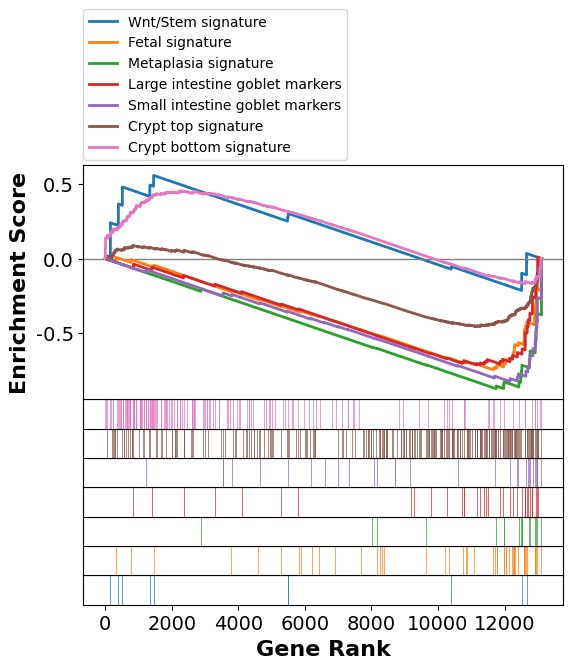

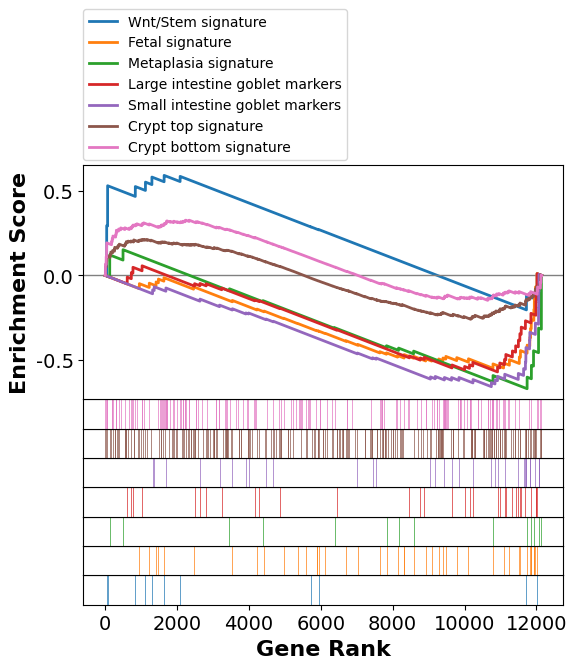

In [81]:
ax_j = gsea_j.plot(
    terms=['Wnt/Stem signature', 'Fetal signature', 'Metaplasia signature', 'Large intestine goblet markers', 'Small intestine goblet markers', 'Crypt top signature', 'Crypt bottom signature'],
    show_ranking=False,
)

ax_c = gsea_c.plot(
    terms=['Wnt/Stem signature', 'Fetal signature', 'Metaplasia signature', 'Large intestine goblet markers', 'Small intestine goblet markers', 'Crypt top signature', 'Crypt bottom signature'],
    show_ranking=False,
)

## Module score of DEGs across all MSI CRC patients (Fig. 3e)

### Joanito et al

In [88]:
sc.pp.normalize_total(adata_j_tumor)
sc.pp.log1p(adata_j_tumor)

sc.tl.score_genes(adata_j_tumor, intersecting_up, score_name='intersecting_up', use_raw=False,)
sc.tl.score_genes(adata_j_tumor, intersecting_down, score_name='intersecting_dw', use_raw=False)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


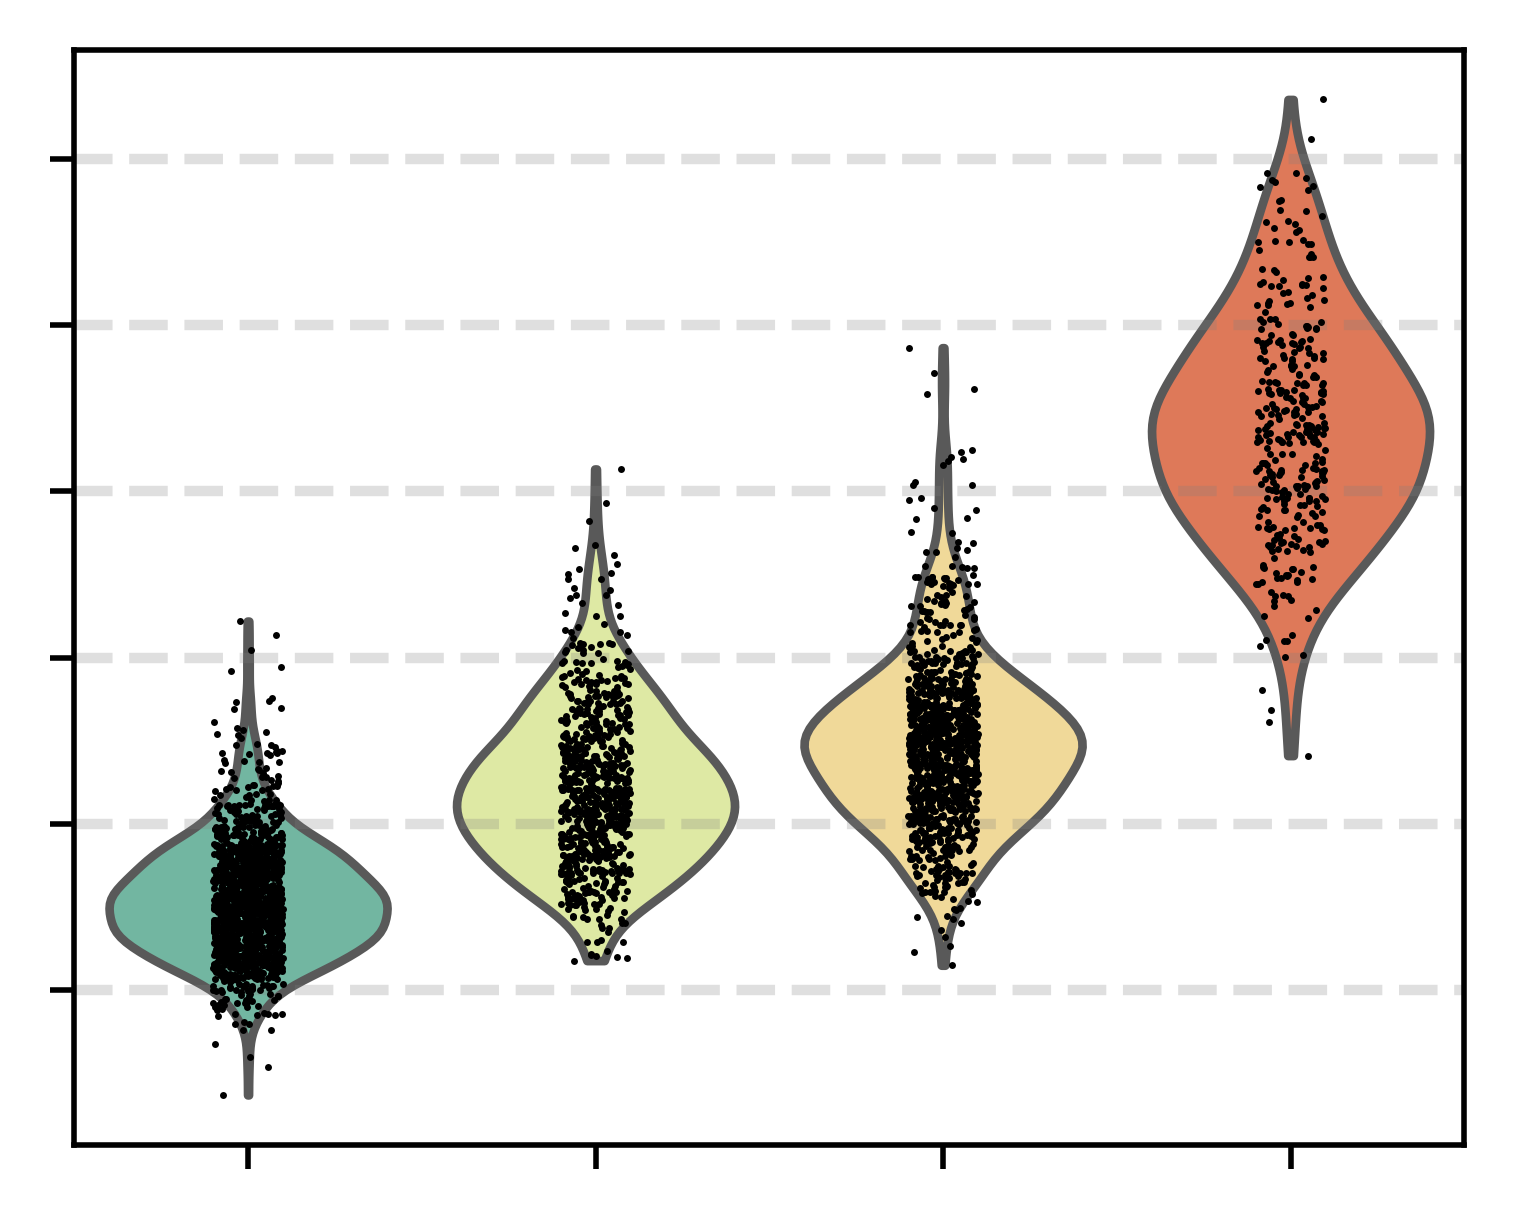

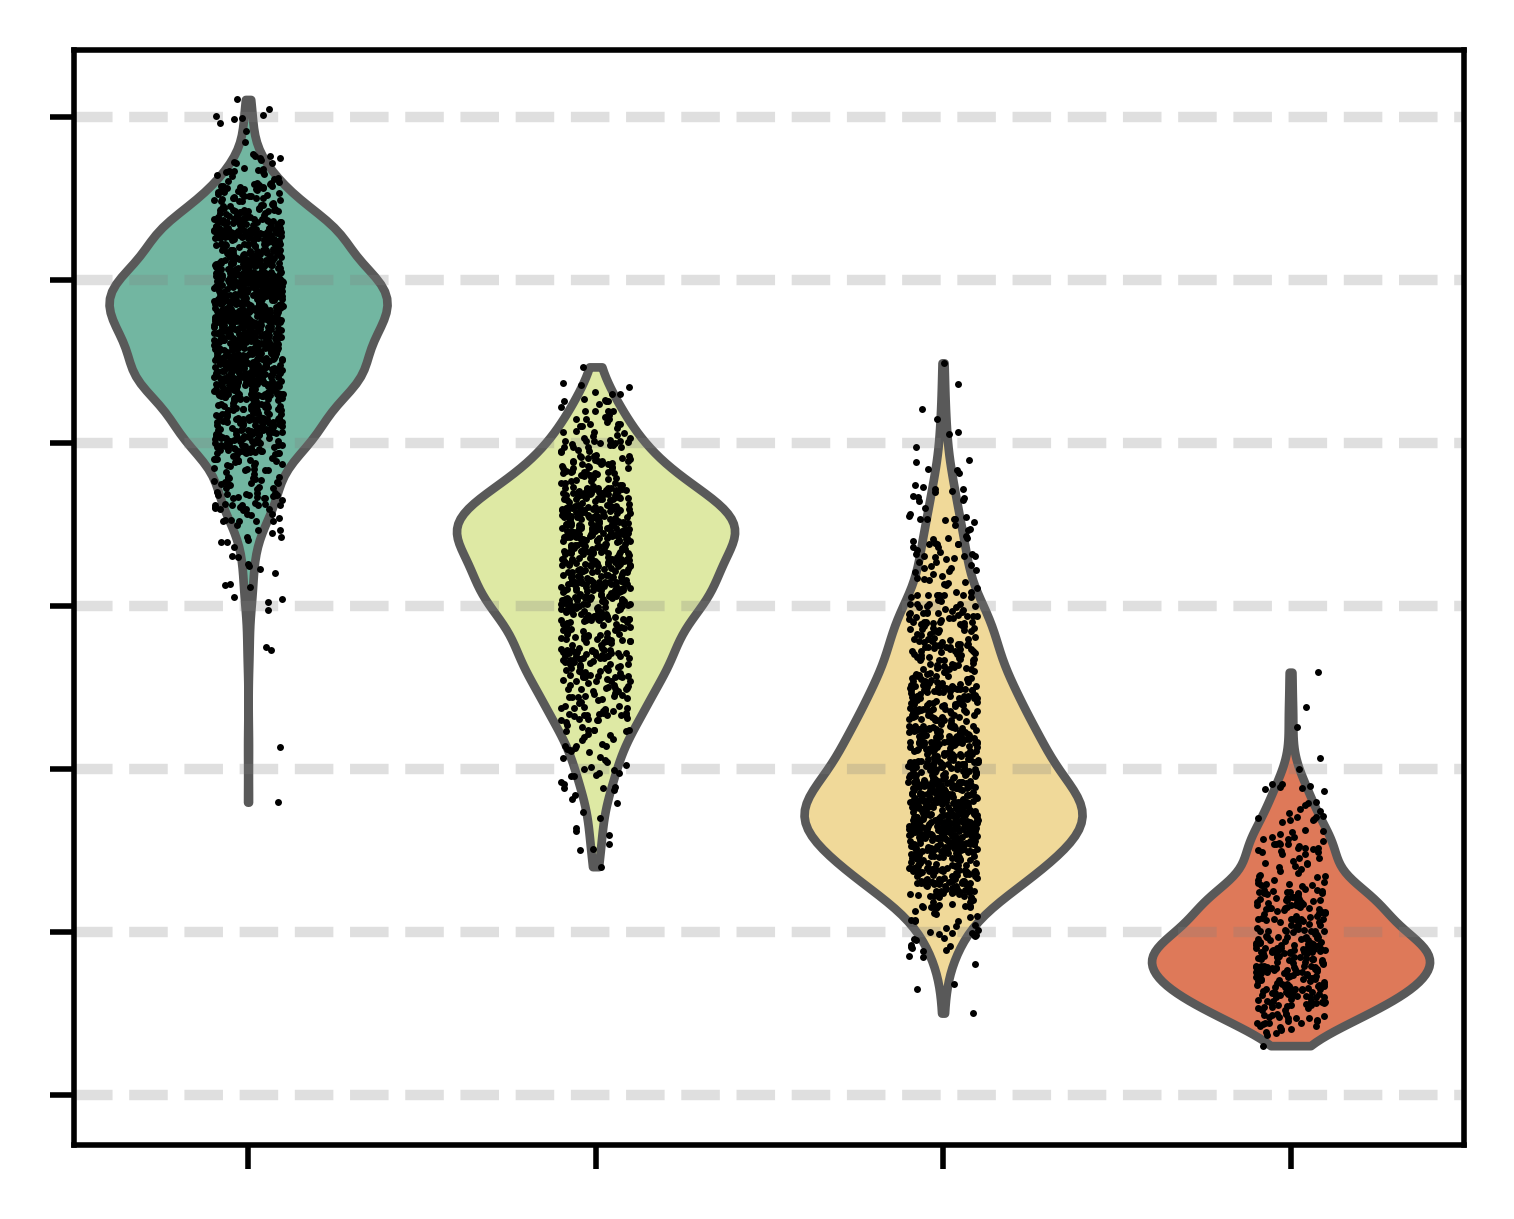

In [118]:
with plt.rc_context({"figure.dpi": (500), 'figure.figsize':(4, 3)},):
    ax = sc.pl.violin(adata_j_tumor, keys=['intersecting_up'], groupby='PatientID', 
                      order=['CRC2817', 'CRC2783', 'SC035', 'SC044'],
                 palette=sns.color_palette("Spectral", as_cmap=False, n_colors=4)[::-1],
                 show=False,
                 )
    ax.set_xlabel('');
    ax.set_ylabel('');
    ax.set_xticklabels([]);
    ax.set_yticklabels([]);
    for i in [ -.2, -.1, 0, .1, .2, .3 ]:
        plt.axhline( i, color='gray', ls='--', alpha=0.25, )

    
with plt.rc_context({"figure.dpi": (500), 'figure.figsize':(4, 3)},):
    ax = sc.pl.violin(adata_j_tumor, keys=['intersecting_dw'], groupby='PatientID', 
                      order=['CRC2817', 'CRC2783', 'SC035', 'SC044'], 
                 palette=sns.color_palette("Spectral", as_cmap=False, n_colors=4)[::-1],
                 show=False,
                 )
    ax.set_xlabel('');
    ax.set_ylabel('');
    ax.set_xticklabels([]);
    ax.set_yticklabels([]);
    for i in [ -.4, -.2, 0, .2, .4, .6, .8 ]:
        plt.axhline( i, color='gray', ls='--', alpha=0.25, )

### Chen et al

In [93]:
sc.pp.normalize_total(adata_c_tumor)
sc.pp.log1p(adata_c_tumor)

sc.tl.score_genes(adata_c_tumor, intersecting_up, score_name='intersecting_up', use_raw=False)
sc.tl.score_genes(adata_c_tumor, intersecting_down, score_name='intersecting_dw', use_raw=False)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


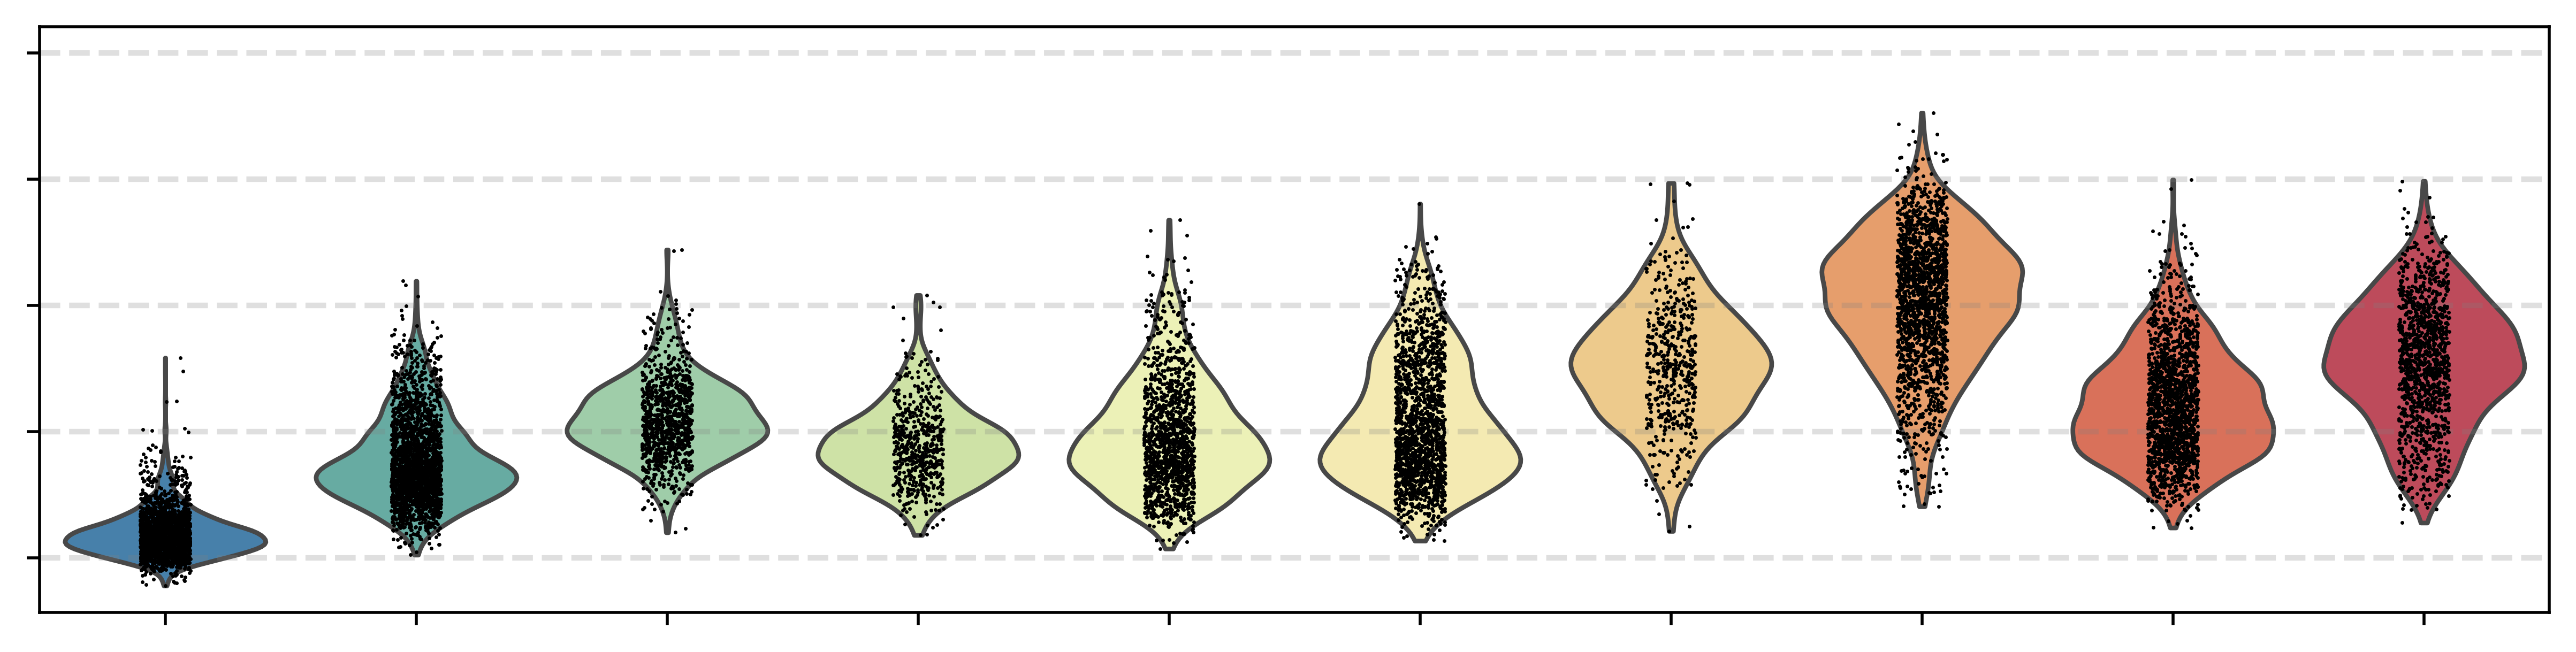

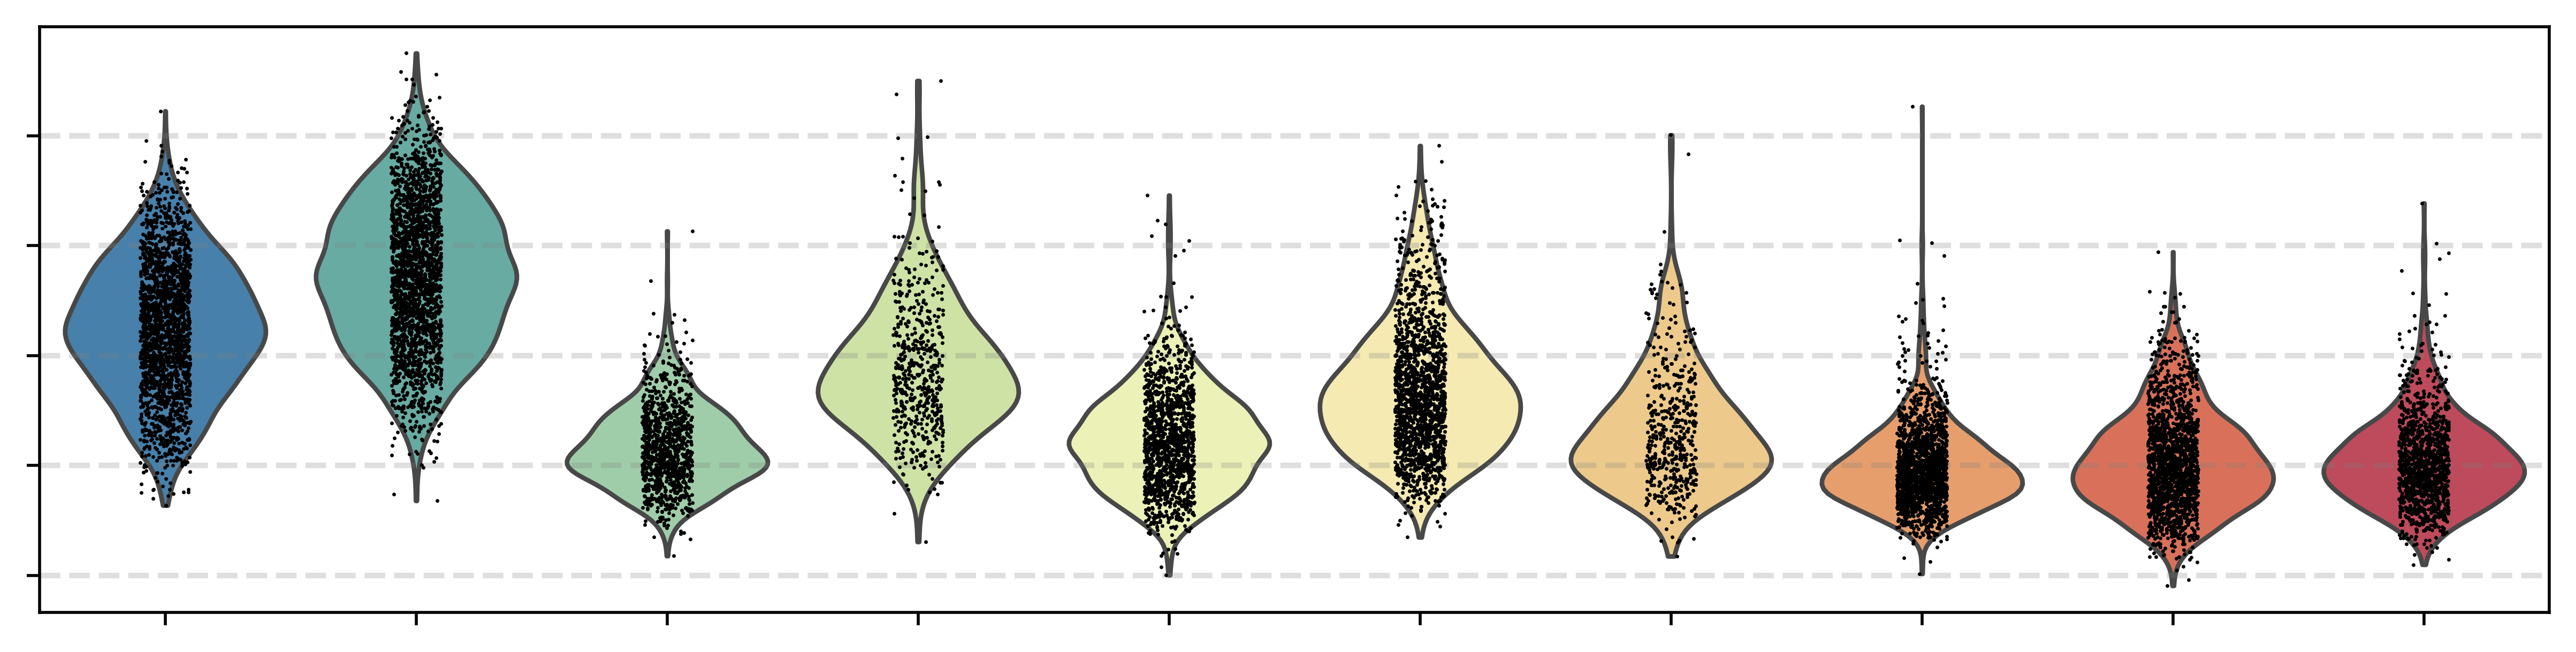

In [115]:
with plt.rc_context({"figure.dpi": (500), 'figure.figsize':(10, 3)},):
    ax = sc.pl.violin(adata_c_tumor, keys=['intersecting_up'], groupby='PatientID', 
                      order=['P18', 'P17', 'P26', 'P15', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04'],
                 palette=sns.color_palette("Spectral", as_cmap=False, n_colors=10)[::-1],
                 show=False,
                 )
    ax.set_xlabel('');
    ax.set_ylabel('');
    ax.set_xticklabels([]);
    ax.set_yticklabels([]);
    for i in [ -.1, 0, .1, .2, .3 ]:
        plt.axhline( i, color='gray', ls='--', alpha=0.25, )

with plt.rc_context({"figure.dpi": (500), 'figure.figsize':(10, 3)},):
    ax = sc.pl.violin(adata_c_tumor, keys=['intersecting_dw'], groupby='PatientID', 
                      order=['P18', 'P17', 'P26', 'P15', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04'],
                 palette=sns.color_palette("Spectral", as_cmap=False, n_colors=10)[::-1],
                 show=False,
                 )
    ax.set_xlabel('');
    ax.set_ylabel('');
    ax.set_xticklabels([]);
    ax.set_yticklabels([]);
    for i in [ -.1, 0, .1, .2, .3 ]:
        plt.axhline( i, color='gray', ls='--', alpha=0.25, )

## Module score of DEGs within SC035 subclusters (Fig. 3f)

In [23]:
adata_j_tumor_SC035 = sc.read_h5ad(f'{DIR_OUT}/adata_j.preprocessed.NanoMnT.TumorLabeled.epithelial.SC035.h5ad')
adata_j_tumor_SC035 = adata_j_tumor_SC035.raw.to_adata()

sc.tl.score_genes(adata_j_tumor_SC035, intersecting_up, score_name='intersecting_up', )
sc.tl.score_genes(adata_j_tumor_SC035, intersecting_down, score_name='intersecting_dw',)

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:916: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


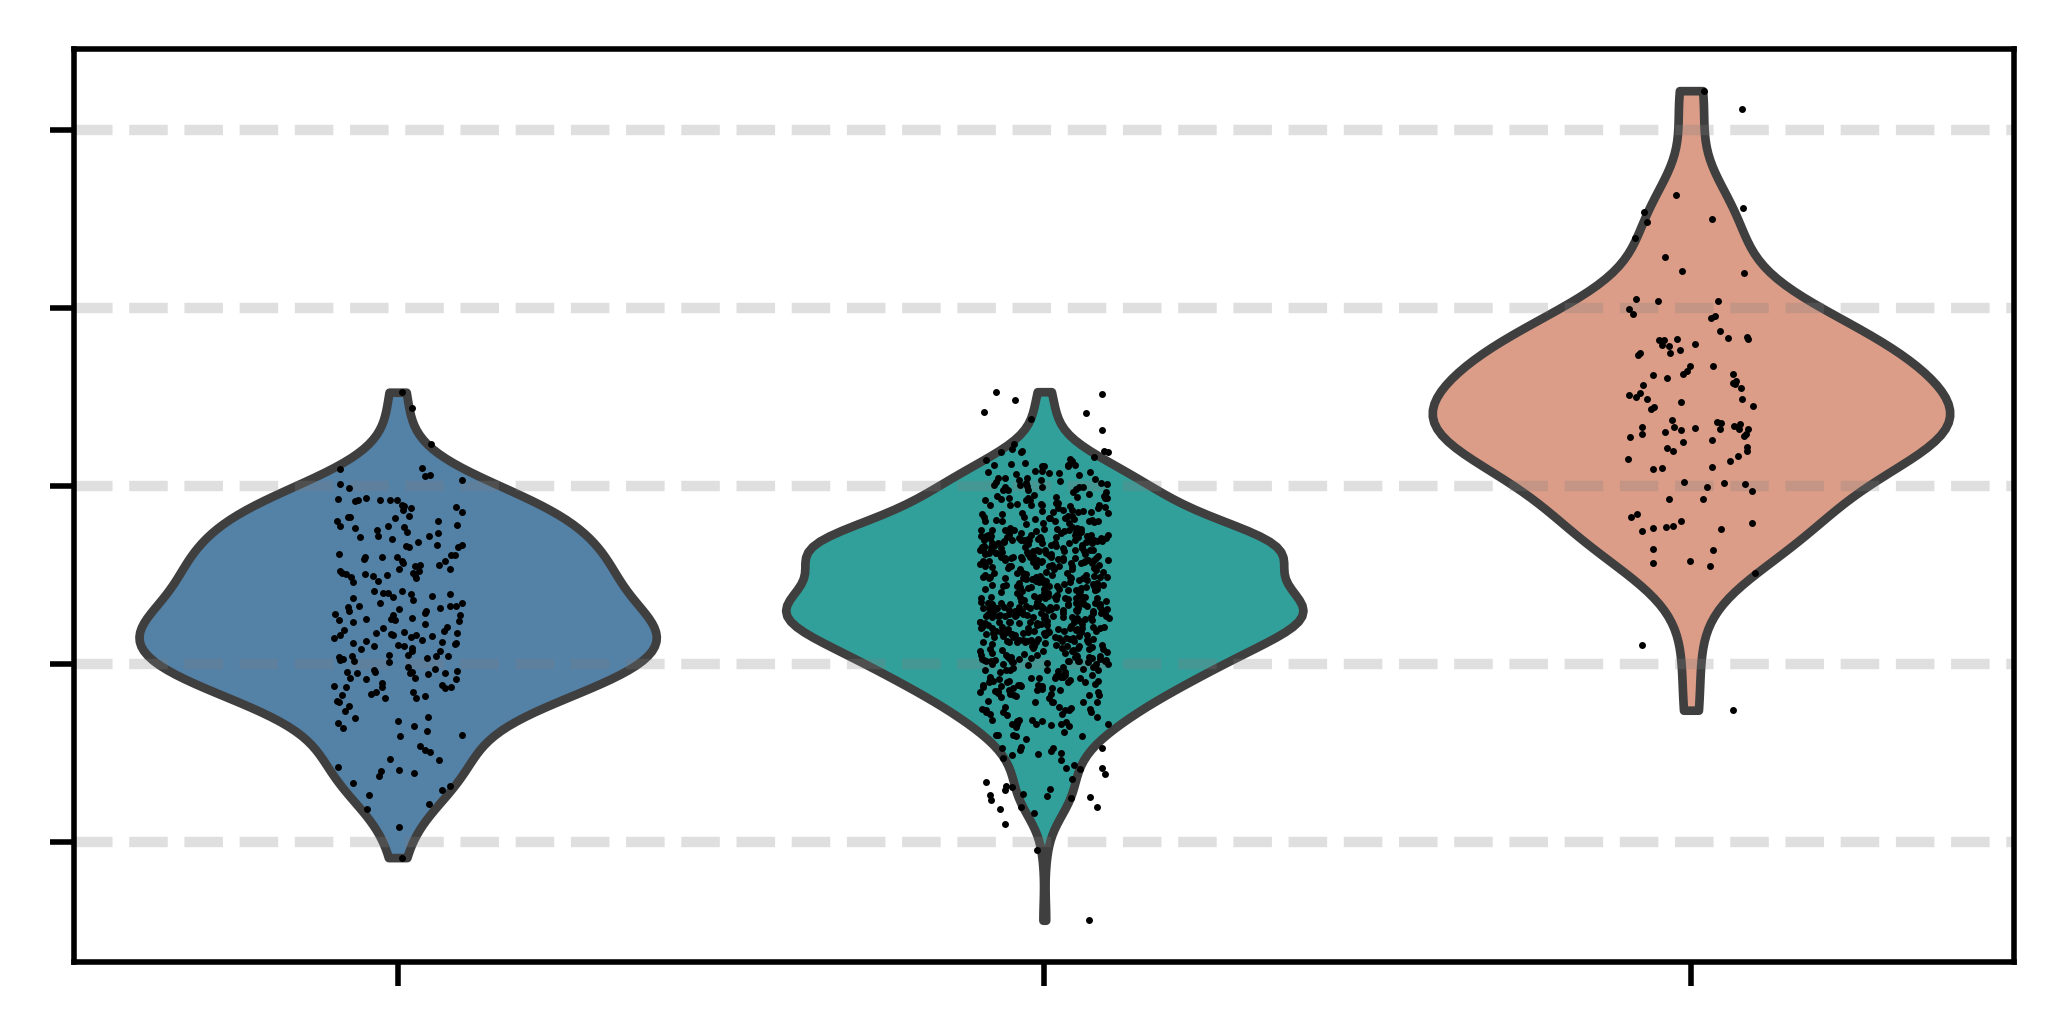

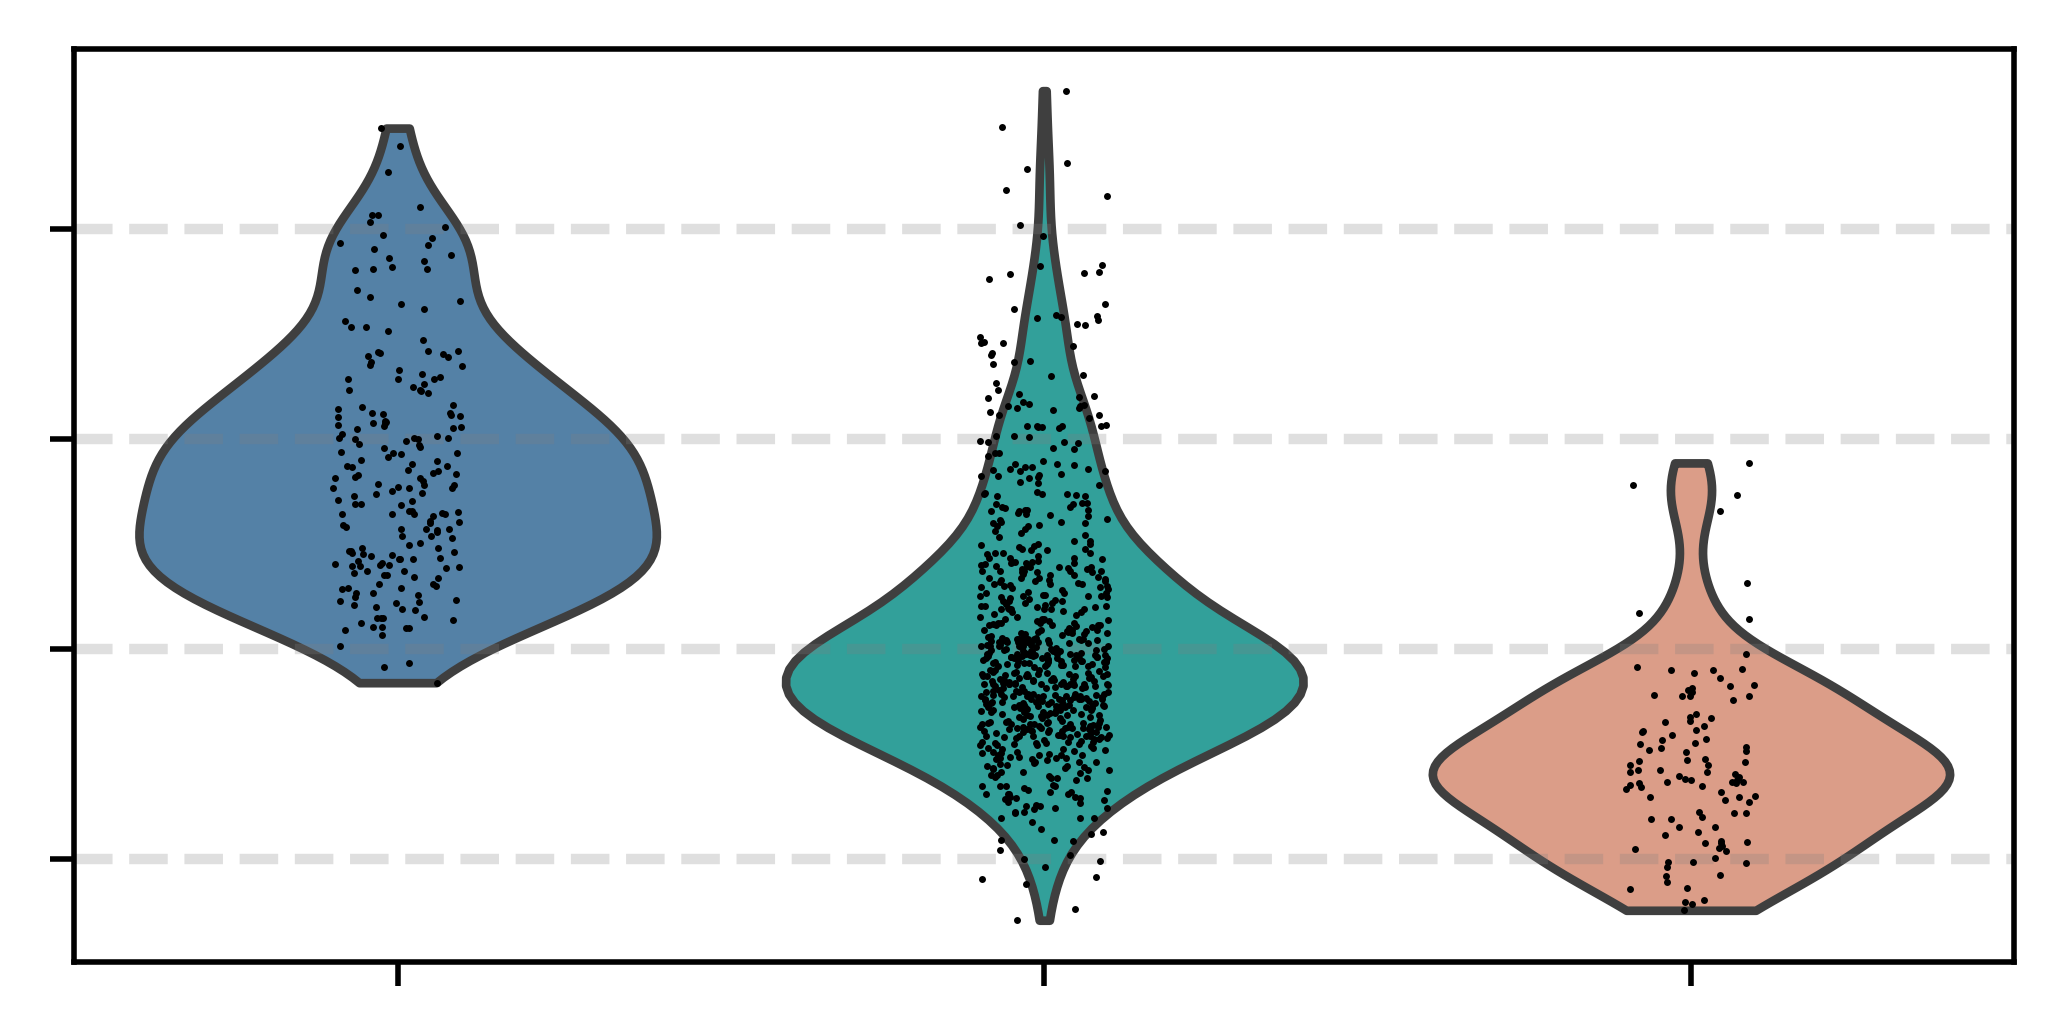

In [138]:


with plt.rc_context({"figure.dpi": (500), 'figure.figsize':(5, 2.5)},):
    ax = sc.pl.violin(adata_j_tumor_SC035, keys=['intersecting_up'], groupby='SC035_subLeiden', order=['1', '0', '2'], show=False, 
                      palette={'0' : 'lightseagreen', '1' : 'steelblue', '2' : 'darksalmon',},)
    ax.set_xlabel('');
    ax.set_ylabel('');
    ax.set_xticklabels([]);
    ax.set_yticklabels([]);
    for i in [ -.1, 0, .1, .2, .3 ]:
        plt.axhline( i, color='gray', ls='--', alpha=0.25, )
    
with plt.rc_context({"figure.dpi": (500), 'figure.figsize':(5, 2.5)},):
    ax = sc.pl.violin(adata_j_tumor_SC035, keys=['intersecting_dw'], groupby='SC035_subLeiden', order=['1', '0', '2'], show=False,
                      palette={'0' : 'lightseagreen', '1' : 'steelblue', '2' : 'darksalmon',},)
    ax.set_xlabel('');
    ax.set_ylabel('');
    ax.set_xticklabels([]);
    ax.set_yticklabels([]);
    for i in [ 0, .2, .4, .6 ]:
        plt.axhline( i, color='gray', ls='--', alpha=0.25, )

## MMR gene expression (Fig. 3g)

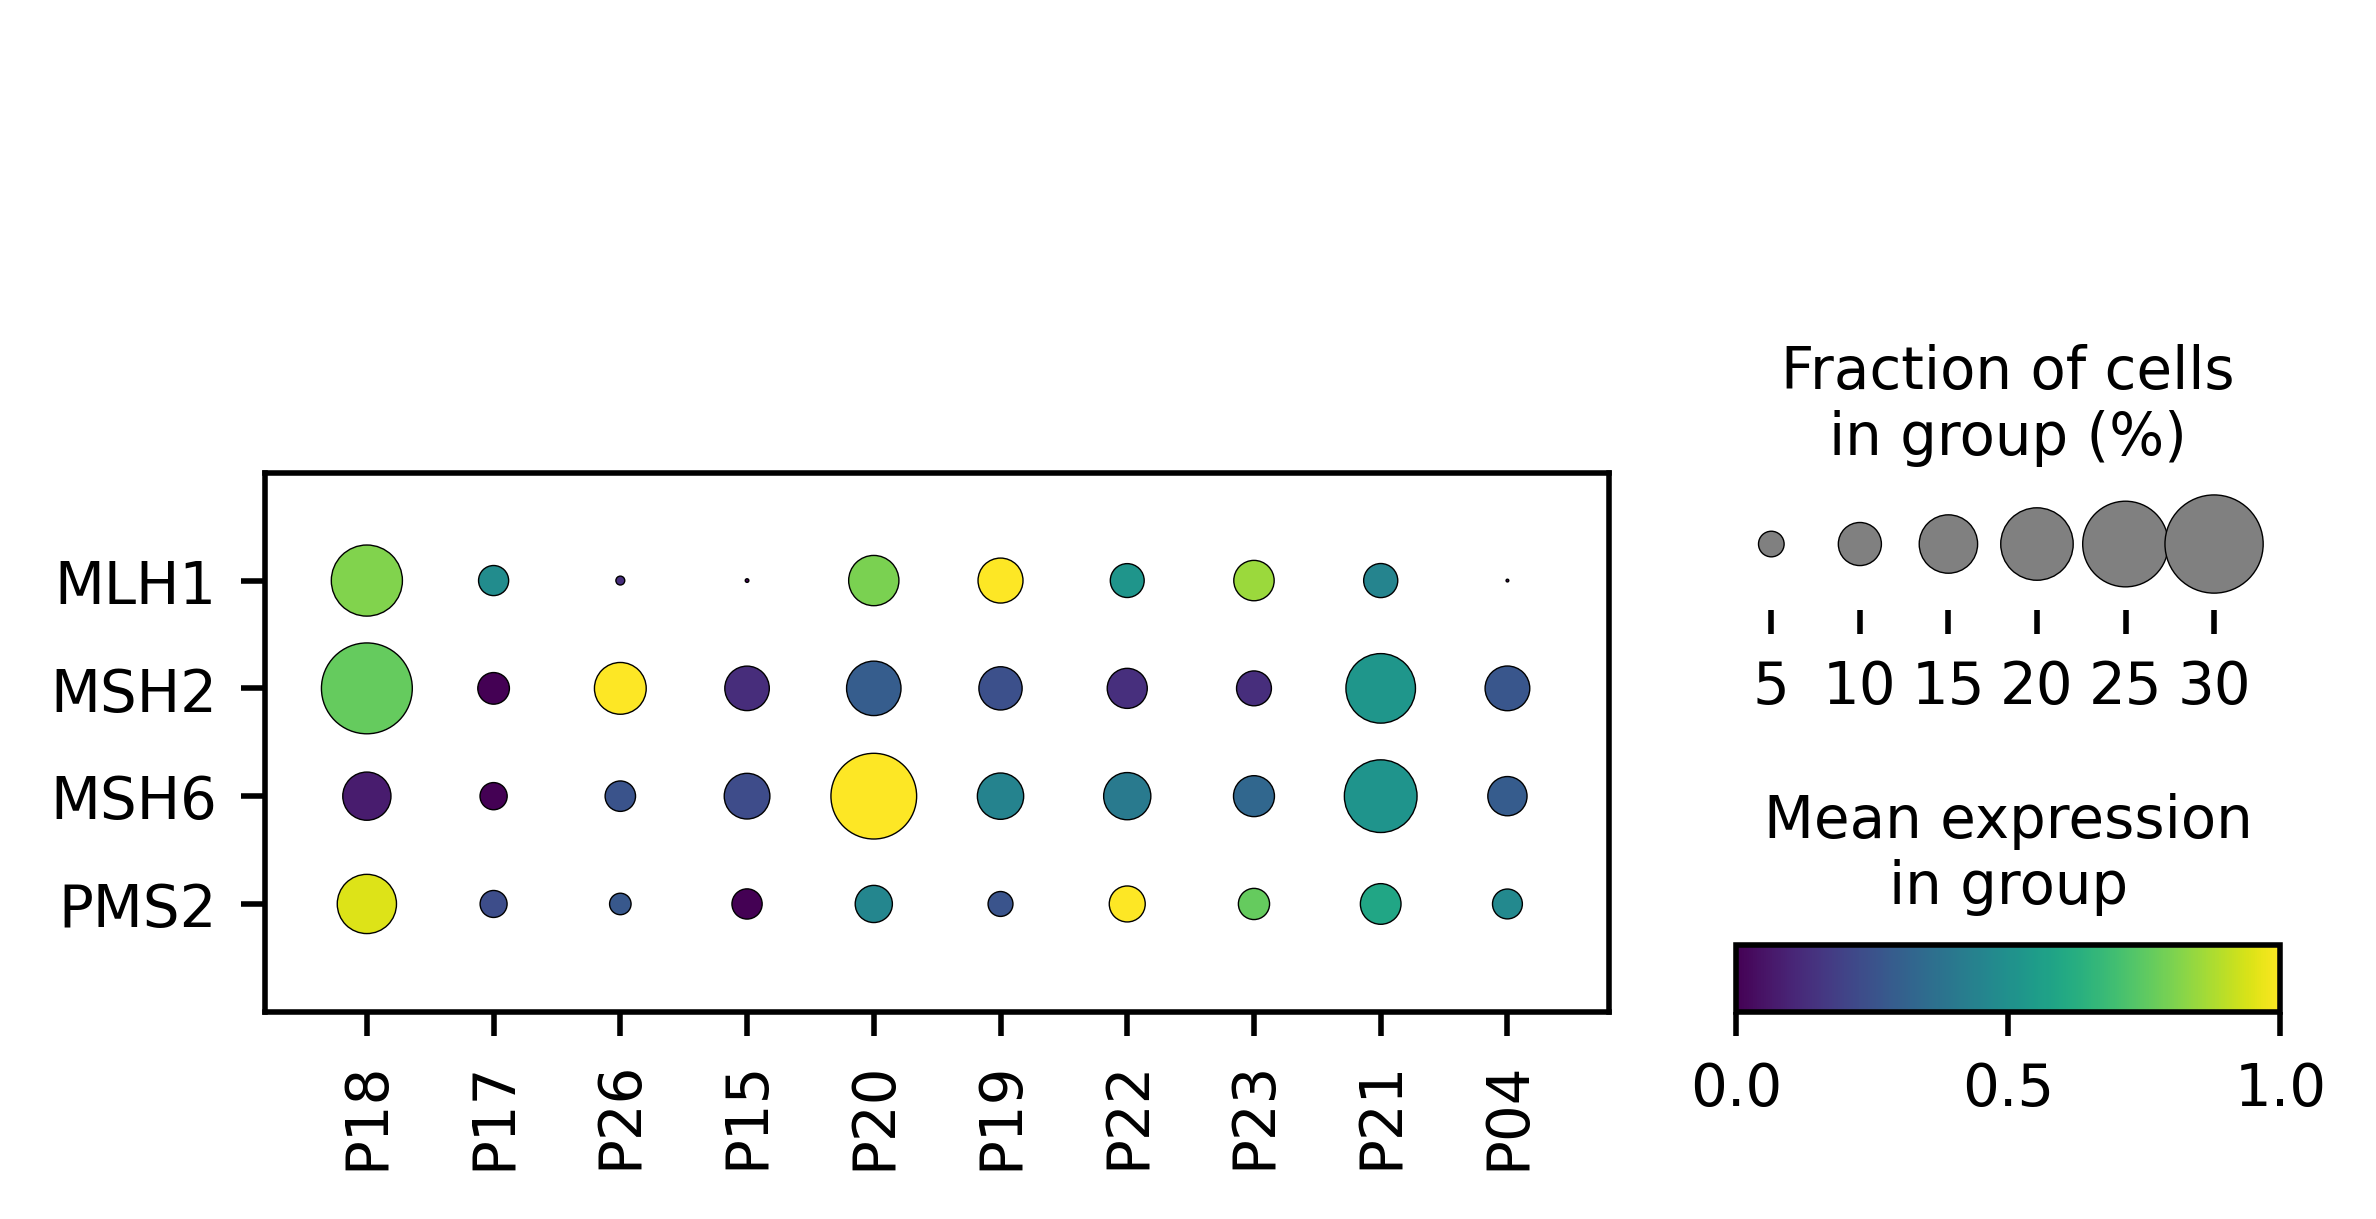

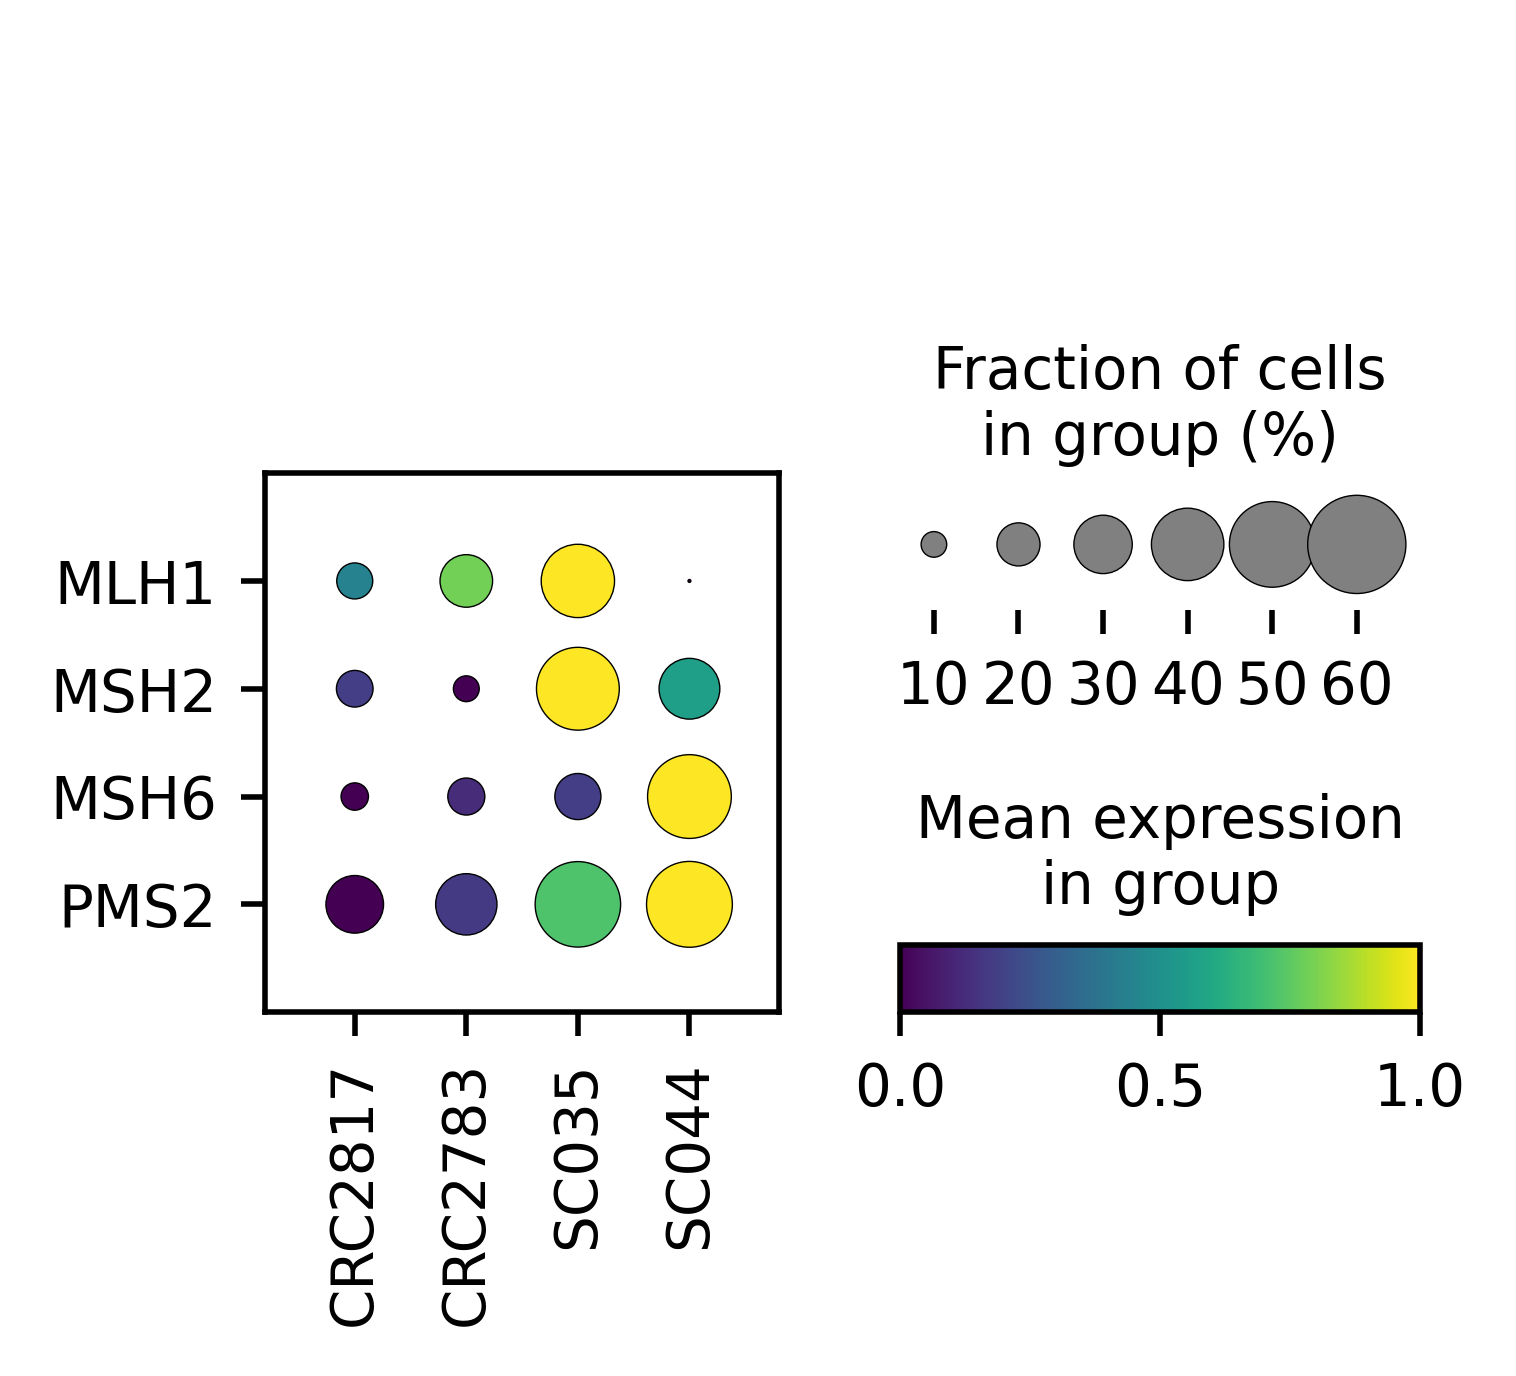

In [145]:
with plt.rc_context({"figure.dpi": (500), 'figure.figsize':(10, 1)},):
    sc.pl.dotplot(adata_c_tumor, var_names=['MLH1', 'MSH2', 'MSH6', 'PMS2'], use_raw=False,
                          groupby='PatientID', categories_order=['P18', 'P17', 'P26', 'P15', 'P20', 'P19', 'P22', 'P23', 'P21', 'P04'], 
                          standard_scale='var',
                          cmap='viridis', show=False, swap_axes=True)
    sc.pl.dotplot(adata_j_tumor, var_names=['MLH1', 'MSH2', 'MSH6', 'PMS2'], use_raw=False,
                     groupby='PatientID', categories_order=['CRC2817', 'CRC2783', 'SC035', 'SC044'],
                    standard_scale='var',
                     cmap='viridis', swap_axes=True)